In [4]:
library(bsts)

Loading required package: BoomSpikeSlab
Loading required package: Boom
Loading required package: MASS

Attaching package: ‘Boom’

The following object is masked from ‘package:stats’:

    rWishart


Attaching package: ‘BoomSpikeSlab’

The following object is masked from ‘package:stats’:

    knots

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: xts

Attaching package: ‘bsts’

The following object is masked from ‘package:BoomSpikeSlab’:

    SuggestBurn



In [11]:
library(seasonal)

In [1]:
library(wmtsa)

In [12]:
library(Rlibeemd)

If you installed Rlibeemd from CRAN, consider installing again from GitHub if you wish to support for parallel computations: https://github.com/helske/Rlibeemd.


In [15]:
library(Kendall)

In [1]:
library(wavelets)

In [2]:
library(WaveletArima)

In [115]:
library(wavethresh)

Loading required package: MASS
WaveThresh: R wavelet software, release 4.6.8, installed

Copyright Guy Nason and others 1993-2016

Note: nlevels has been renamed to nlevelsWT



In [16]:
library(forecast)
library(ncdf4)
library(ggplot2)

#library(tseries)
#library(MASS)
#library(fitdistrplus)
#library(zoo)

In [3]:
fuzzify<-function(x)
{
  idx = (x == 0)
    if(sum(idx) != 0){
  y <- array(0.0 ,length(x))
  y[idx] <- x[idx] + 0.005*runif(1,min=0.0, max=1.0) 
  y[!idx]<-x[!idx] + 0.005*runif(1,min=-1.0, max=1.0)
    return(y)
}
 return(x) 
}

In [4]:
phase_average<-function(x, freq)
{    
  N = length(x)
  result = numeric(N)
  averages = numeric(freq)
  stds = numeric(freq)    
  for (j in 1:freq){
        Idx = seq(j,N,12)
        averages[j] = mean(x[Idx])
        stds[j] = sd(x[Idx])
      if(stds[j] == 0){
          result[Idx] =  0
      }else{
        result[Idx] = (x[Idx] - averages[j])/stds[j]
          }
      
      }
    returnList <- list("result" = result, "averages" = averages, "stds" = stds)
    return(returnList)  
}

In [5]:
inv_phase_average<-function(x, freq, avg, std)
{    
  N = length(x)
  result = numeric(N)  
  for (j in 1:freq){
        Idx = seq(j,N,freq)
        result[Idx] = x[Idx]* std[j] + avg[j]      
      }
    return(result)  
}

In [6]:
inBoxCox<-function(x, lambda){
 if(lambda == 0){
    inv_x = exp(x)
    } else{
     inx_x = (x*lambda + 1) ^ (1/lambda)
 }
    return(inx_x)
}

In [172]:
data <- read.csv("precipitation.csv", header=TRUE, sep=",")
lon <- read.csv("lon.csv", header=TRUE, sep=",")
lat <- read.csv("lat.csv", header=TRUE, sep=",")

lon<-lon[["X0"]]
lat<-lat[["X0"]]

n_train = 20
# Set forecasting window length (in years)
n_test = 3
# Set start year
start_year = 1948
# Set annual sampling rate
f = 12
h = n_test * f 

skill <- list()

length.lon = dim(data)[1]
length.lat = dim(data)[2]
L = dim(data)[1]

df.A<-data.frame( as.numeric, as.numeric, as.numeric, as.numeric)
names(df.A)<-c("lon","lat","RMSE","MAE")

df.E<-data.frame( as.numeric, as.numeric, as.numeric, as.numeric)
names(df.E)<-c("lon","lat","RMSE","MAE")

In [173]:
for(j in c(2:L)){
  
  x <- data[,j]
  x <- sapply(x, fuzzify)
  
  end_year = start_year + ((L -(L %% f))/f)
  
  RMSE.A = array(0.0, (end_year-(n_train+n_test))-start_year+1)
  MAE.A = array(0.0, (end_year-(n_train+n_test))-start_year+1)
  
  RMSE.E = array(0.0, (end_year-(n_train+n_test))-start_year+1)
  MAE.E = array(0.0, (end_year-(n_train+n_test))-start_year+1)
  
  x.ts <- x[1:length(x)-1]
  origin = start_year - 1
  N = length(x.ts)
  
  for(i in seq(1,N/f - n_train - n_test + 1)){
    
    train_start = (i - 1)*f + 1
    train_end = train_start+n_train*f -1
    
    test_start = train_end + 1
    test_end = test_start + n_test*f -1
    
    
    x.train <- x[train_start:train_end]
    x.test <- x[test_start:test_end]  
    
    x.train <- ts(x.train, start = c(origin+i, 1), freq=f)
    x.test <- ts(x.test, start = c(origin+i+n, 1), freq=f)
    
    lambda <- BoxCox.lambda(x.train)
    #OM
    #A = forecast(auto.arima(x.train),h=h)$mean
    #E = forecast(ets(x.train),h=h)$mean
    
    #OM + BC
    #ABC = forecast(auto.arima(x.train,lambda=lambda), h=h, lambda=lambda, biasadj=TRUE)$mean
    #EBC = forecast(ets(x.train,lambda=lambda), h=h, lambda=lambda, biasadj=FALSE)$mean
    
    #OM + BC + ZT
    x.train.t <- BoxCox(x.train, lambda)
    m = mean(x.train.t)
    s = sd(x.train.t)
    x.train.t = (x.train.t - m)/s
    
    ABCZT = forecast(auto.arima(x.train.t),h=h)$mean
    ABCZT = ABCZT*s + m
    ABCZT = invBoxCox(ABCZT,lambda)
    
    EBCZT = forecast(ets(x.train.t),h=h)$mean
    EBCZT = EBCZT*s + m
    EBCZT = invBoxCox(EBCZT,lambda)
    
    #OM + PA
    #pa = phase_average(x.train, f)
    #x.train.t <- ts(pa$result, start = c(origin, 1), freq=f)
    
    #APA = forecast(auto.arima(x.train.t),h=h)$mean
    #APA = inv_phase_average(APA, f, pa$averages, pa$stds)
    
    #EPA = forecast(ets(x.train.t),h=h)$mean
    #EPA = inv_phase_average(EPA, f, pa$averages, pa$stds)
    
    #OM + BC + PA
    #x.train.t <- BoxCox(x.train, lambda)
    #pa = phase_average(x.train.t, f)
    #x.train.t <- ts(pa$result, start = c(origin, 1), freq=f)
    
    #ABCPA = forecast(auto.arima(x.train.t),h=h)$mean
    #ABCPA = inv_phase_average(ABCPA, f, pa$averages, pa$stds)
    #ABCPA = invBoxCox(ABCPA,lambda)
    
    #EBCPA= forecast(ets(x.train.t),h=h)$mean
    #EBCPA = inv_phase_average(EBCPA, f, pa$averages, pa$stds)
    #EBCPA = invBoxCox(EBCPA,lambda)
    
    #E + STL
    #ES = forecast(stl(x.train,s.window="periodic", robust = TRUE), h=h, biasadj=FALSE)$mean
    
    #E + BC + STL
    #x.fit = stl(BoxCox(x.train,lambda), s.window="periodic", robust = TRUE)
    #EBCSTL = forecast(x.fit, h=h, lambda=lambda, biasadj=FALSE)$mean

    error.A = accuracy(ABCZT, x.test)
    error.E = accuracy(EBCZT, x.test)

    RMSE.A[i] = as.numeric(error.A[1,2])
    MAE.A[i] = as.numeric(error.A[1,3])
    
    RMSE.E[i] = as.numeric(error.E[1,2])
    MAE.E[i] = as.numeric(error.E[1,3])
    
  }
  
  # Now calculate average forecast errors
  meanRMSE.A = mean(RMSE.A, na.rm=TRUE)
  meanRMSE.E = mean(RMSE.E, na.rm=TRUE)
  
  meanMAE.A = mean(MAE.A, na.rm=TRUE)
  meanMAe.E = mean(MAE.E, na.rm=TRUE)
  
  de.A<-data.frame(lon[i],lat[j],meanRMSE.A, meanMAE.A)
  de.E<-data.frame(lon[i],lat[j],meanRMSE.E, meanMAE.E)
  
  names(de.A)<-c("lon","lat","meanRME", "meanMAE")
  names(de.E)<-c("lon","lat","meanRME", "meanMAE")
  
  write.table(de.A, "ABCZTTemp.csv", sep = ",", col.names = !file.exists("ABCZT.csv"), append = T)
  write.table(de.E, "EBCZTTemp.csv", sep = ",", col.names = !file.exists("EBCZT.csv"), append = T)
  
  df.A <- rbind(df.A,de.A)
  df.E <- rbind(df.E,de.E) 
}

In [ ]:
write.csv(df.A, file = "ABCZT.csv")
write.csv(df.E, file = "EBCZT.csv")

In [175]:
RMSE.E

[1] 12.02011 11.40349  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000
 [9]  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000
[17]  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000
[25]  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000
[33]  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000
[41]  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000

In [140]:
accuracy(A, x.test)

ME        RMSE     MAE      MPE       MAPE     ACF1      Theil's U
Test set -2.068299 17.19368 11.49008 -19726.64 19746.13 0.3813933 2.381093

In [141]:
accuracy(E, x.test)

ME       RMSE     MAE      MPE       MAPE     ACF1      Theil's U
Test set 4.470731 14.80421 6.371032 -1345.916 1390.636 0.3391855 0.7384448

In [142]:
accuracy(ABC, x.test)

ME        RMSE     MAE      MPE       MAPE     ACF1      Theil's U
Test set -18.32667 41.02189 18.69663 -3789.632 3796.301 0.2609978 3.22454

In [143]:
accuracy(EBC, x.test)

ME        RMSE     MAE      MPE       MAPE     ACF1      Theil's U
Test set -3.088679 7.731743 3.882608 -422.3701 434.0894 0.3992961 1.079909

In [146]:
accuracy(ABCPA, x.test)

ME       RMSE     MAE      MPE       MAPE     ACF1      Theil's U
Test set -1.47591 10.39427 5.470796 -386.4057 403.5029 0.4356203 0.6886225

In [147]:
accuracy(EBCPA, x.test)

ME        RMSE    MAE      MPE       MAPE     ACF1      Theil's U
Test set -1.476127 10.3944 5.470917 -386.4287 403.5256 0.4356272 0.6886195

In [148]:
accuracy(ES, x.test)

ME        RMSE     MAE      MPE      MAPE     ACF1      Theil's U
Test set -7.483721 16.55837 8.893229 99.56993 1325.538 0.5322301 1.295531

In [149]:
accuracy(EBCSTL, x.test)

ME        RMSE     MAE     MPE       MAPE     ACF1      Theil's U
Test set -5.993038 11.71805 6.79265 -957.6655 973.4735 0.5675843 2.016936

In [132]:
ES = forecast(stl(x.train,s.window="periodic", robust = TRUE), h=h, biasadj=FALSE)$mean

In [139]:
accuracy(A, x.test)

ME        RMSE     MAE      MPE       MAPE     ACF1      Theil's U
Test set -2.068299 17.19368 11.49008 -19726.64 19746.13 0.3813933 2.381093

In [134]:
x.fit = stl(BoxCox(x.train,lambda), s.window="periodic", robust = TRUE)
EBCSTL = forecast(x.fit, h=h, lambda=lambda, biasadj=FALSE)$mean

In [128]:
m

[1] -0.1816911

In [18]:
x.test

        Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct
1966  40.13  12.34  27.10  24.98  46.09  18.13   5.76  12.03  37.26 125.63
1967  22.92 123.50  23.85  63.72  10.25  35.32   0.39  24.18 110.82  11.85
1968  17.60  54.19  69.86  40.94  70.31  16.82   0.53  11.58  21.99   7.58
1969  72.44  22.75  33.72 125.39                                          
        Nov    Dec
1966  40.24   7.66
1967  80.53  41.43
1968  47.34 100.51
1969              

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


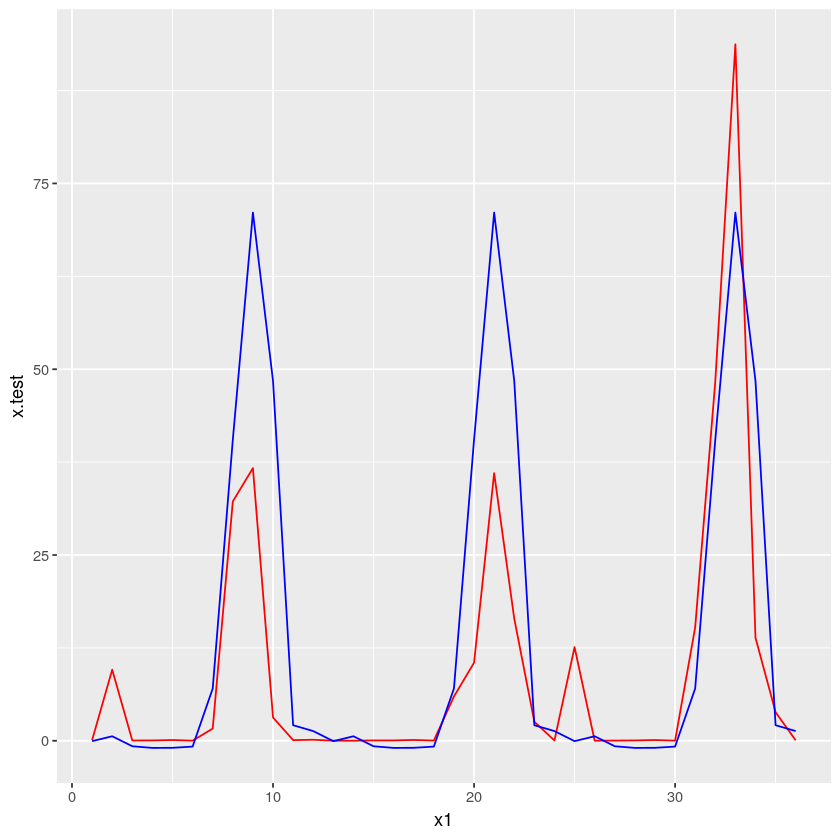

In [159]:
model = ES

x1 <- seq(length(x.test))

df <- data.frame(x1,x.test,model)

require(ggplot2)

ggplot(df, aes(x1)) +                    # basic graphical object
  geom_line(aes(y=x.test), colour="red") +  # first layer
  geom_line(aes(y=model), colour="blue") 

In [167]:
spiParameters<-function(x, n_months){
    x.n = rollapply(x, n_months, sum)
    fit.gamma <- fitdist(x, distr = "gamma", method = "mle")
    #probabilities = pgamma(x.n, shape = fit.gamma$estimate[1], rate = fit.gamma$estimate[2])
    #result = qnorm(probabilities, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)
    return(fit.gamma)
}

In [158]:
spiGenerator<-function(x, n_months){
    x.n = rollapply(x, n_months, sum)
    fit.gamma <- fitdist(x, distr = "gamma", method = "mle")
    probabilities = pgamma(x.n, shape = fit.gamma$estimate[1], rate = fit.gamma$estimate[2])
    result = qnorm(probabilities, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)
    return(result)
}

In [168]:
x.train.param = spiParameters(as.numeric(x.train),3)

In [164]:
x.train.spi = spiGenerator(as.numeric(x.train),3)

In [165]:
x.train.spi <- ts(x.train.spi, start = c(origin, 3), freq=f)

In [127]:
x.3 = rollapply(x, 3, sum)

In [142]:
fit.gamma <- fitdist(x, distr = "gamma", method = "mle")

In [150]:
probabilities = pgamma(x.3, shape = fit.gamma$estimate[1], rate = fit.gamma$estimate[2])

In [155]:
spi3 = qnorm(probabilities, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)

# ANOVA

In [5]:
error <- read.csv("error1.csv", header=TRUE, sep=",")

In [6]:
res.aov <- aov(error ~ group, data = error)

In [7]:
summary(res.aov)

              Df  Sum Sq Mean Sq F value   Pr(>F)    
group          4   11755  2938.9   5.416 0.000241 ***
Residuals   3170 1720212   542.7                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [8]:
TukeyHSD(res.aov)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = error ~ group, data = error)

$group
                  diff        lwr         upr     p adj
APA-A      -3.48941724 -7.0576083  0.07877382 0.0588520
E-A         0.70867216 -2.8595189  4.27686323 0.9829116
EPA-A      -3.40352179 -6.9717129  0.16466927 0.0699516
PROAPA-A   -3.72886149 -7.2970526 -0.16067043 0.0353826
E-APA       4.19808941  0.6298983  7.76628047 0.0116624
EPA-APA     0.08589545 -3.4822956  3.65408652 0.9999958
PROAPA-APA -0.23944425 -3.8076353  3.32874681 0.9997489
EPA-E      -4.11219395 -7.6803850 -0.54400289 0.0144467
PROAPA-E   -4.43753366 -8.0057247 -0.86934259 0.0062607
PROAPA-EPA -0.32533970 -3.8935308  3.24285136 0.9991553


In [39]:
tst1 <- function(...) stop("dummy error")

In [40]:
try(tst1(1:10, long, calling, expression))

In [86]:
iter <- 12
test <- function(iter){
    
    if(iter > 10) stop("too many iterations")
    result = numeric(10)
    for(i in c(1:10)){
        result[i] = i*0.1
        }
    return(result)
    }


In [80]:
for(i in c(1,12,3,12,5)){
    t = try(test(i))
    print(i)
    print(t)
    }

[1] 1
 [1]  1  2  3  4  5  6  7  8  9 10
[1] 12
[1] "Error in test(i) : too many iterations\n"
attr(,"class")
[1] "try-error"
attr(,"condition")
<simpleError in test(i): too many iterations>
[1] 3
 [1]  1  2  3  4  5  6  7  8  9 10
[1] 12
[1] "Error in test(i) : too many iterations\n"
attr(,"class")
[1] "try-error"
attr(,"condition")
<simpleError in test(i): too many iterations>
[1] 5
 [1]  1  2  3  4  5  6  7  8  9 10


In [89]:
t = try(test(1))

In [91]:
if(is.numeric(t)){print('hi')
                  }else{
    
}

[1] "hi"


In [125]:
accuracy(A, x.test)

ME       RMSE     MAE      MPE       MAPE     ACF1      Theil's U
Test set 3.684994 15.93579 10.37169 -2799.752 2829.148 0.2935152 1.564264

In [127]:
A[30] = NA

In [105]:
d = matrix(0.0,n,h)

In [43]:
stop("too many iterations")

ERROR: Error in eval(expr, envir, enclos): too many iterations


# Date Reading

In [288]:
nc <- nc_open("spi3_6_12_1deg_cru_ts_3_21_1949_2012.nc")

lat <- ncvar_get(nc,"lat",verbose=F)
lon <- ncvar_get(nc,"lon",verbose=F)

time <- ncvar_get(nc,"time",verbose=F)

#attributes(nc$var)$nameas

spi3 <- ncvar_get(nc, attributes(nc$var)$names[1])

lat[104]

lon[219]

data<-spi3[219,104,]

[1] 13.5

[1] 38.5

In [2]:
nc <- nc_open("GPCC_half.nc")

lat <- ncvar_get(nc,"lat",verbose=F)
lon <- ncvar_get(nc,"lon",verbose=F)

In [3]:
precip <- ncvar_get(nc, attributes(nc$var)$names[1])

In [4]:
lat[54]

[1] 13.25

In [5]:
lon[137]

[1] 38.25

In [6]:
x<-precip[137,54,]

In [62]:
length(x)

[1] 841

In [38]:
nc <- nc_open("precipitation.nc")

lat <- ncvar_get(nc,"lat",verbose=F)
lon <- ncvar_get(nc,"lon",verbose=F)

In [39]:
attributes(nc$var)$names

[1] "precip"

In [40]:
precip <- ncvar_get(nc, attributes(nc$var)$names[1])

In [60]:
lat[11]

[1] 13.75

In [61]:
lon[26]

[1] 38.75

In [204]:
data<-precip[26,11,]

ERROR: Error in precip[26, 11, ]: incorrect number of dimensions


In [205]:
data <- data[!is.na(data)]

In [9]:
#t <- read.csv("precipitationBWh.csv", header=TRUE, sep=",")
#x<-t[["X0"]]

In [223]:
x <- fuzzify(data)

In [65]:
BWh <- read.csv("BWh.csv", header=TRUE, sep=",")

In [169]:
Af <- read.csv("Af.csv", header=TRUE, sep=",")

In [23]:
AW <- read.csv("Aw.csv", header=TRUE, sep=",")

In [64]:
BSh <- read.csv("BSh.csv", header=TRUE, sep=",")

In [133]:
data <- read.csv("precipitation.csv", header=TRUE, sep=",")
lon <- read.csv("lon.csv", header=TRUE, sep=",")
lat <- read.csv("lat.csv", header=TRUE, sep=",")

In [2]:
load("data.RData")
load("lat.RData")
load("lon.RData")

In [36]:
lon<-lon[["X0"]]

ERROR: Error in lon[["X0"]]: subscript out of bounds


In [37]:
lat<-lat[["X0"]]

ERROR: Error in lat[["X0"]]: subscript out of bounds


In [5]:
MannKendall(x)

tau = -0.00656, 2-sided pvalue =0.77602

# EEDM

In [9]:
x<-data[4,5,]

In [13]:
x.ts<-ts(x, start = c(1946, 1), freq=f)

In [25]:
n=20
# Set forecasting window length (in years)
m=3
# Set start year
start = 1946
origin = 1982
# Set annual sampling rate
f = 12
h = m*f

In [29]:
func <- function(x, h){forecast(auto.arima(x), h=h)}

In [33]:
e <- tsCV(x.ts, func, h=h,window=20 * 12)

In [31]:
dim(e)

[1] 841  36

In [10]:
#x <- fuzzify(x)

n=20
# Set forecasting window length (in years)
m=3
# Set start year
start = 1946
origin = 1982
# Set annual sampling rate
f = 12
h = m*f

index = (origin - (start - 1)) * 12 +1

x.ts <- x[index:length(x)-1]
#x.ts<-x
train_start = index
train_end = train_start+n*f-1

test_start = train_end + 1
test_end = test_start + m*f -1

x.train <- x[train_start:train_end]
x.test <- x[test_start:test_end]

#x.ts = ts(x[421:length(x)-1], start=c(origin, 1), freq=f)
x.train <- ts(x.train, start = c(origin, 1), freq=f)
x.test <- ts(x.test, start = c(origin+n, 1), freq=f)

In [13]:
mfs <- eemd(x.train, num_siftings = 10, ensemble_size = 50, threads = 1)

In [22]:
mfs[,i]

          Jan      Feb      Mar      Apr      May      Jun      Jul      Aug
1982 17.50091 17.55483 17.60894 17.66326 17.71777 17.77249 17.82742 17.88258
1983 18.16181 18.21839 18.27522 18.33232 18.38969 18.44733 18.50525 18.56345
1984 18.85893 18.91896 18.97931 19.03999 19.10100 19.16236 19.22405 19.28610
1985 19.60180 19.66607 19.73072 19.79578 19.86123 19.92709 19.99336 20.06004
1986 20.39992 20.46922 20.53898 20.60920 20.67988 20.75104 20.82267 20.89479
1987 21.26281 21.33794 21.41359 21.48976 21.56647 21.64372 21.72151 21.79985
1988 22.19998 22.28173 22.36407 22.44700 22.53052 22.61466 22.69940 22.78476
1989 23.22096 23.31012 23.39994 23.49041 23.58155 23.67336 23.76584 23.85901
1990 24.33525 24.43262 24.53071 24.62952 24.72906 24.82934 24.93037 25.03214
1991 25.55238 25.65875 25.76590 25.87384 25.98258 26.09213 26.20248 26.31364
1992 26.88186 26.99801 27.11503 27.23289 27.35163 27.47123 27.59170 27.71305
1993 28.33320 28.45994 28.58760 28.71619 28.84570 28.97615 29.10754 29.23988

In [17]:
n = dim(mfs)[2]
result = matrix(0.0,n,h)
for(i in c(1:n)){
    #lambda <- BoxCox.lambda(mfs[,i])
    result[i,] = forecast(auto.arima(mfs[,i], biasadj = TRUE),h, biasadj = TRUE)$mean      
}

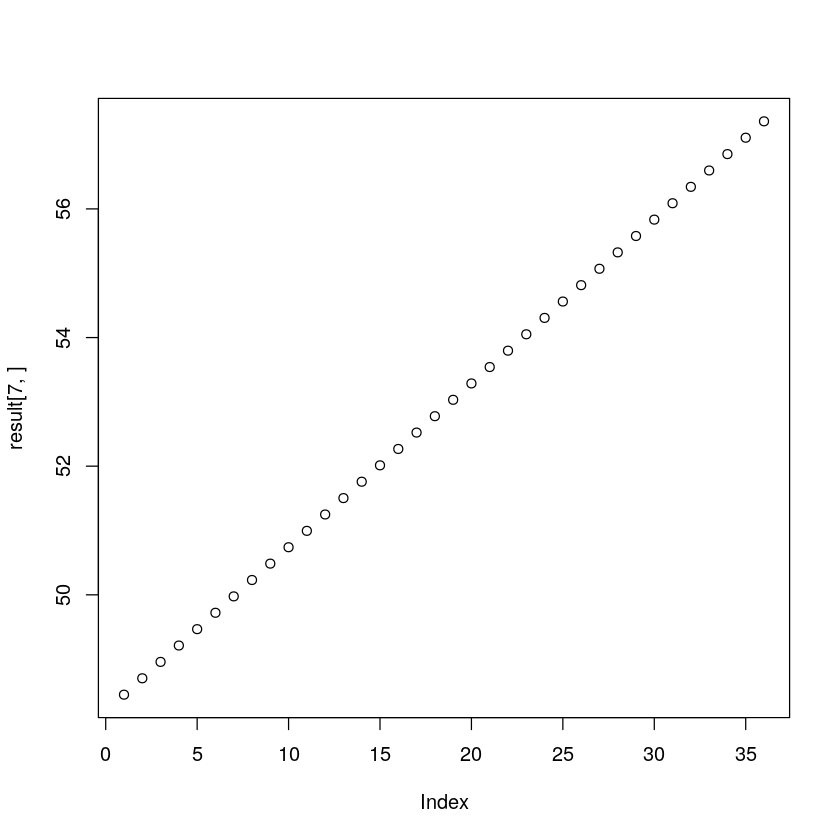

In [18]:
plot(result[7,])

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


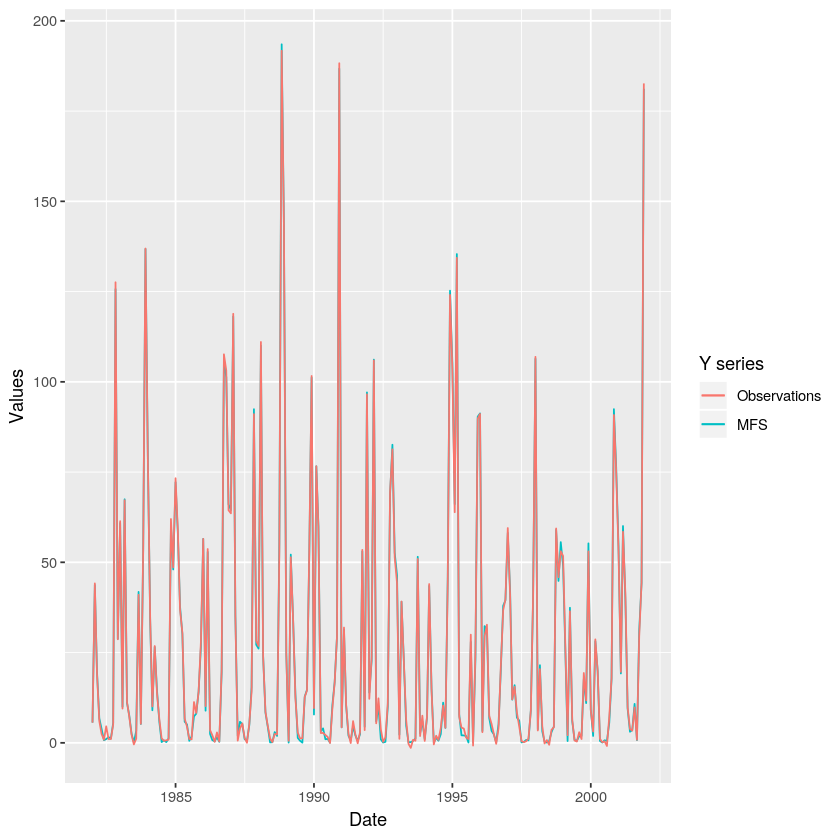

In [21]:
y<-rowSums(mfs)
data <- data.frame(
  date = seq(as.Date("1982/1/1"), by = "month", length.out = length(x.train)),
  x.train,
  y
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.train,colour="red") ) +  # first layer
  geom_line(aes(y=y,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Observations", "MFS"))

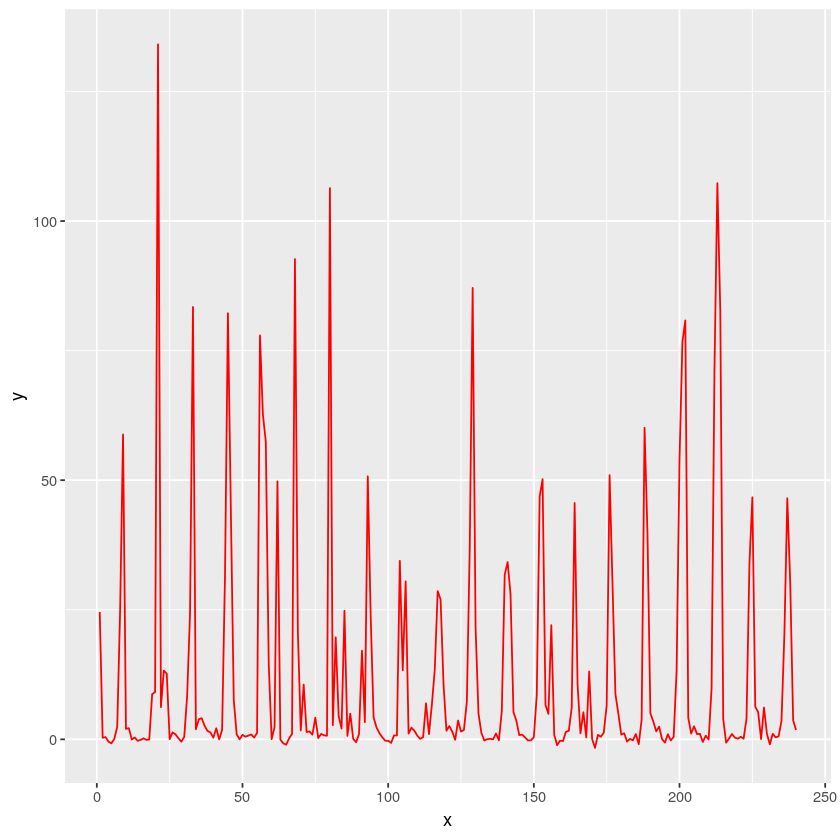

In [15]:
x <- seq(length(y))

df <- data.frame(x,y)

require(ggplot2)

ggplot(df, aes(x)) +                
  geom_line(aes(y=y), colour="red")

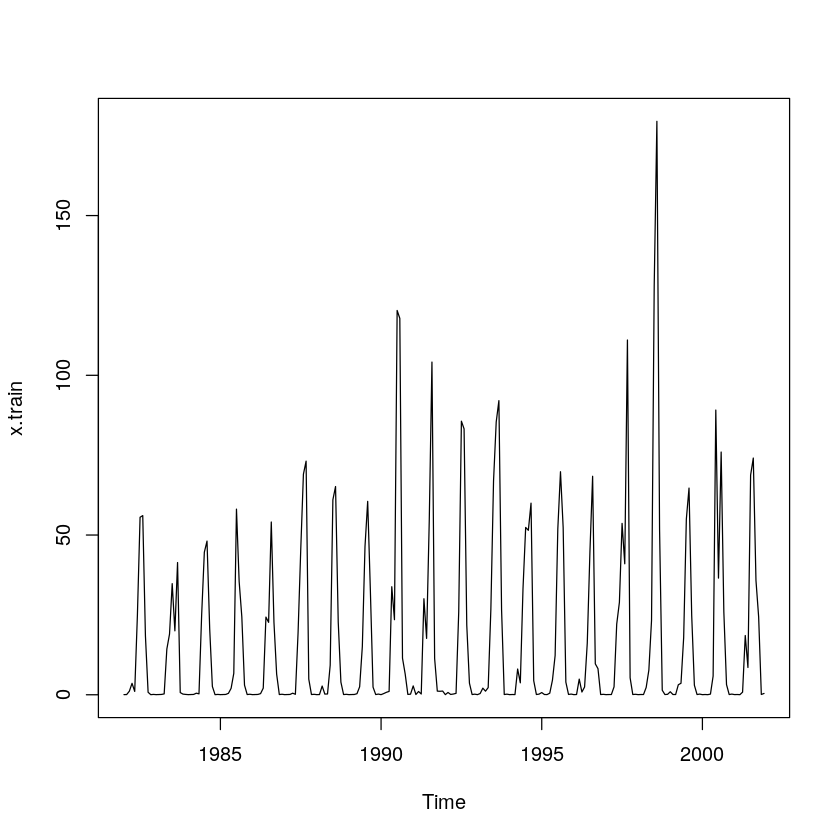

In [32]:
plot(x.train)

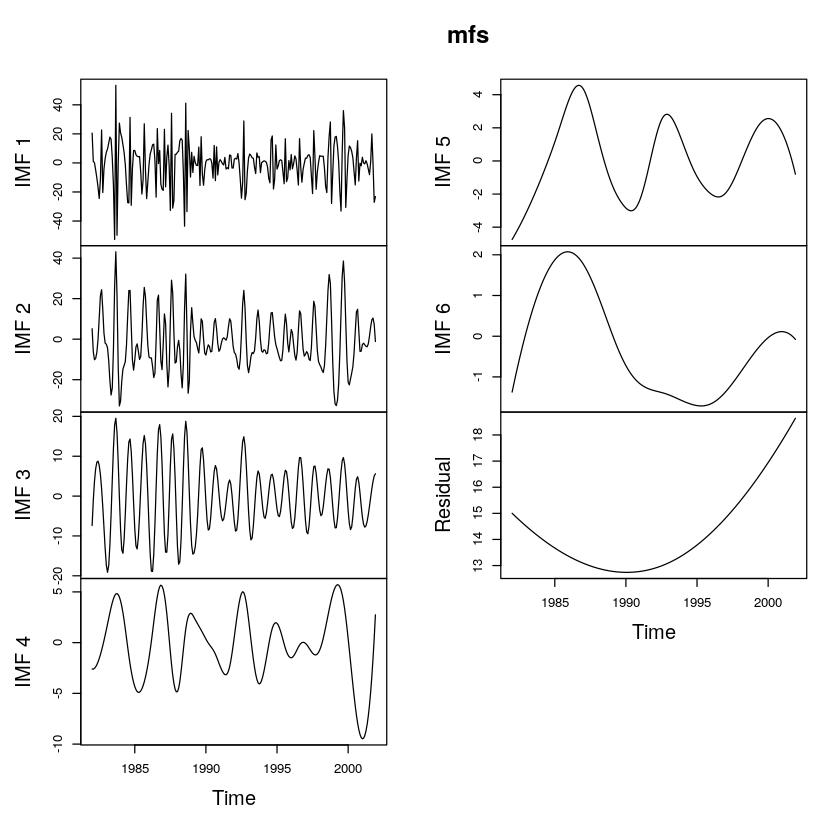

In [13]:
plot(mfs)

In [93]:
a = mfs[,7]

In [88]:
adf.test(a, alternative = "stationary")


	Augmented Dickey-Fuller Test

data:  a
Dickey-Fuller = -1.0077, Lag order = 6, p-value = 0.9357
alternative hypothesis: stationary


In [99]:
a_d = diff(a, lag=6)

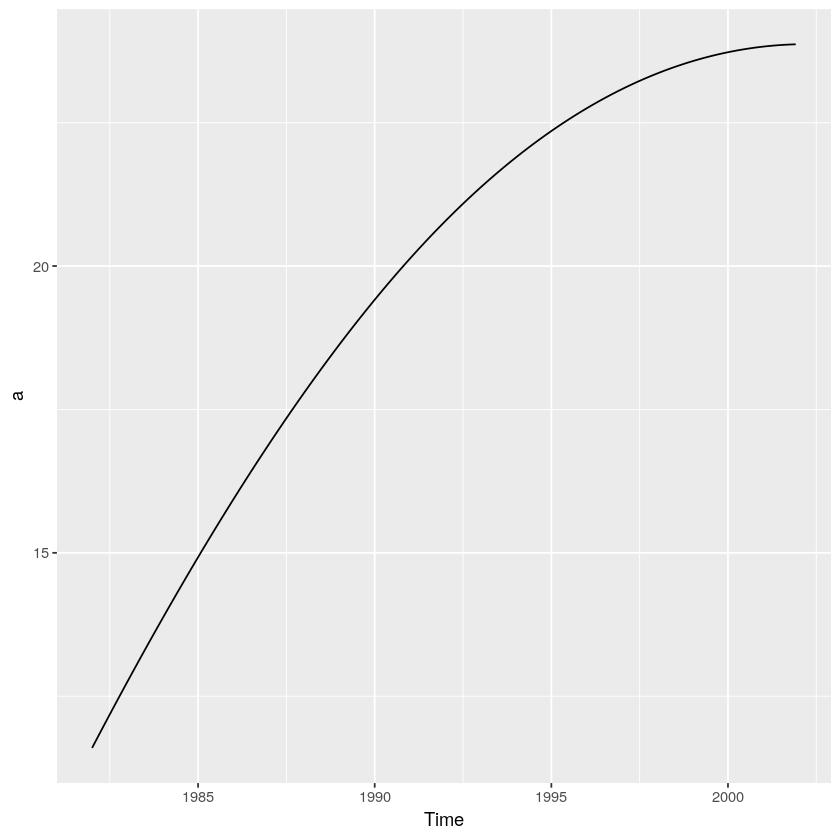

In [101]:
autoplot(a)

In [19]:
A = colSums(result)
A[A<0]<-0
A <- ts(A, start = c(origin+20, 1), freq=f)

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


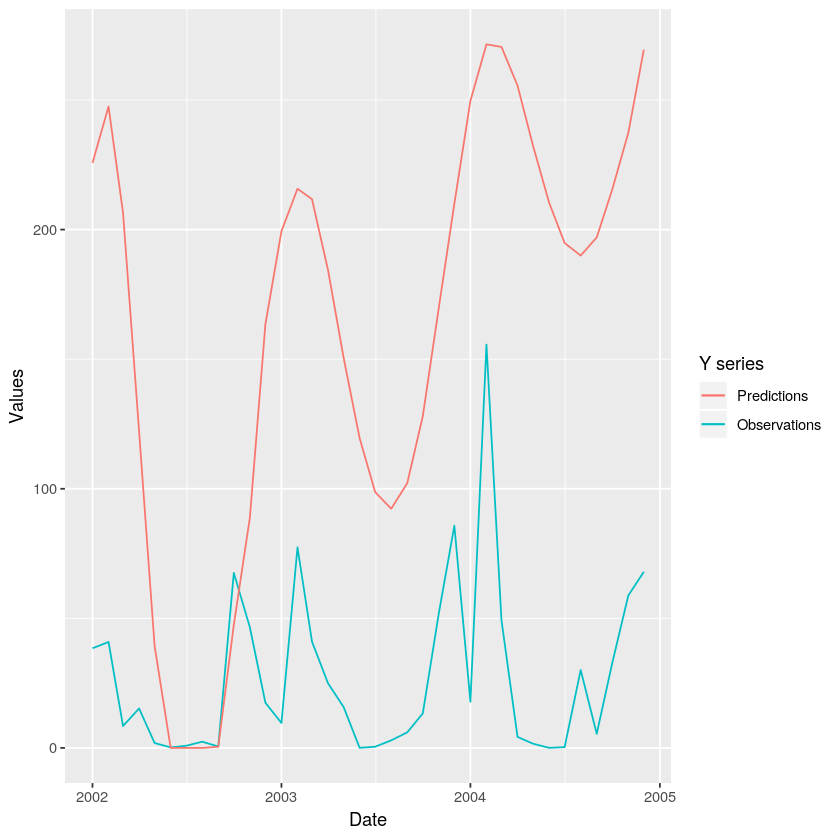

In [20]:
data <- data.frame(
  date = seq(as.Date("2002/1/1"), by = "month", length.out = 36),
  x.test,
  A
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test,colour="red") ) +  # first layer
  geom_line(aes(y=A,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

In [18]:
accuracy(A, x.test)

ME        RMSE     MAE      MPE       MAPE     ACF1      Theil's U
Test set -3.027035 16.96203 13.90518 -7930.678 7952.516 0.3717593 4.647974

In [28]:
A = forecast(auto.arima(x.train),h)$mean

In [29]:
accuracy(A, x.test)

ME        RMSE     MAE      MPE       MAPE     ACF1      Theil's U
Test set -1.470885 12.69779 6.886041 -314.2743 330.8143 0.2249191 1.022587

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


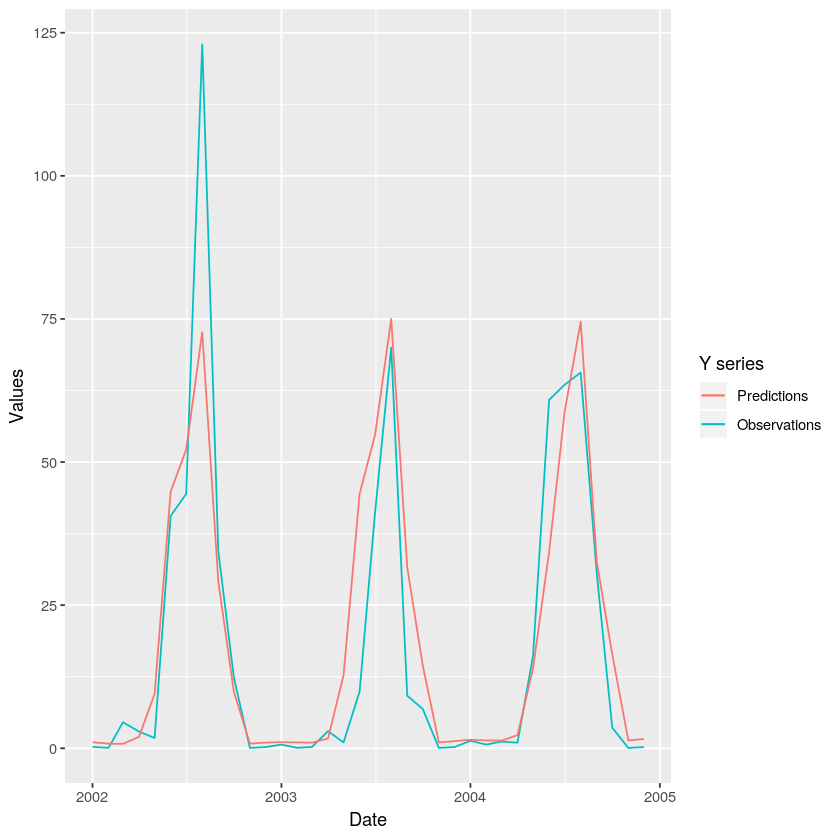

In [30]:
data <- data.frame(
  date = seq(as.Date("2002/1/1"), by = "month", length.out = 36),
  x.test,
  A
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test,colour="red") ) +  # first layer
  geom_line(aes(y=A,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

# Wavelet

In [83]:
x<-data[26,11,]

x <- fuzzify(x)

n=20
# Set forecasting window length (in years)
m=3
# Set start year
start = 1946
origin = 1961
# Set annual sampling rate
f = 12
h = m*f

index = (origin - (start - 1)) * 12 +1

x.ts <- x[index:length(x)-1]
#x.ts<-x
train_start = index
train_end = train_start+n*f-1

test_start = train_end + 1
test_end = test_start + m*f -1

x.train <- x[train_start:train_end]
x.test <- x[test_start:test_end]

In [ ]:
#x.ts = ts(x[421:length(x)-1], start=c(origin, 1), freq=f)
x.train <- ts(x.train, start = c(origin, 1), freq=f)
x.test <- ts(x.test, start = c(origin+n, 1), freq=f)

In [85]:
ox.dwt.01 <- wavDWT(x.train)

In [86]:
ox.dwt.01

Discrete Wavelet Transform of x.train
-------------------------------------
Wavelet                  : s8 
Length of series         : 240 
Number of levels         : 7 
Boundary correction rule : periodic 
Filtering technique      : convolution 
Zero phase shifted       : FALSE 
Crystals                 : d1 d2 d3 d4 d5 d6 d7 s7 extra 

In [93]:
ss<-function(x){ return(sum( (x - mean(x) )^2 ))}

In [92]:
sum(sapply(ox.dwt.01$data,ss))

[1] 1499498

In [96]:
ss(x.train) 

[1] 1562494

In [97]:
sum(sapply(ox.dwt.01$data,ss)) - ss(x.train)

[1] -62995.51

In [98]:
summary(ox.dwt.01)


           Min       1Q  Median      3Q     Max    Mean      SD       Var
d1    -101.494  -15.461  -0.998   7.464 121.579  -2.382  35.026  1226.852
d2    -115.590  -75.119 -42.696   0.108  38.934 -38.460  42.336  1792.359
d3    -233.187 -155.170 -67.126 224.883 380.773   4.199 196.011 38420.347
d4    -104.861  -60.965 -23.964  43.098 126.808  -5.940  70.513  4972.104
d5     -79.396  -51.848  -5.917  23.523  89.178  -7.541  60.376  3645.218
d6     -69.327  -62.500 -55.672 -20.801  14.071 -36.976  44.732  2000.950
d7      74.837   74.837  74.837  74.837  74.837  74.837      NA        NA
s7     729.701  729.701 729.701 729.701 729.701 729.701      NA        NA
extra  239.099  293.722 348.344 430.772 513.200 366.881 137.987 19040.534
          MAD Energy %
d1     18.505    5.783
d2     57.832    7.669
d3    173.373   43.950
d4     66.349    2.765
d5     76.250    0.878
d6     20.246    0.319
d7      0.000    0.221
s7      0.000   20.993
extra 161.967   17.422

Energy Distribution:
       

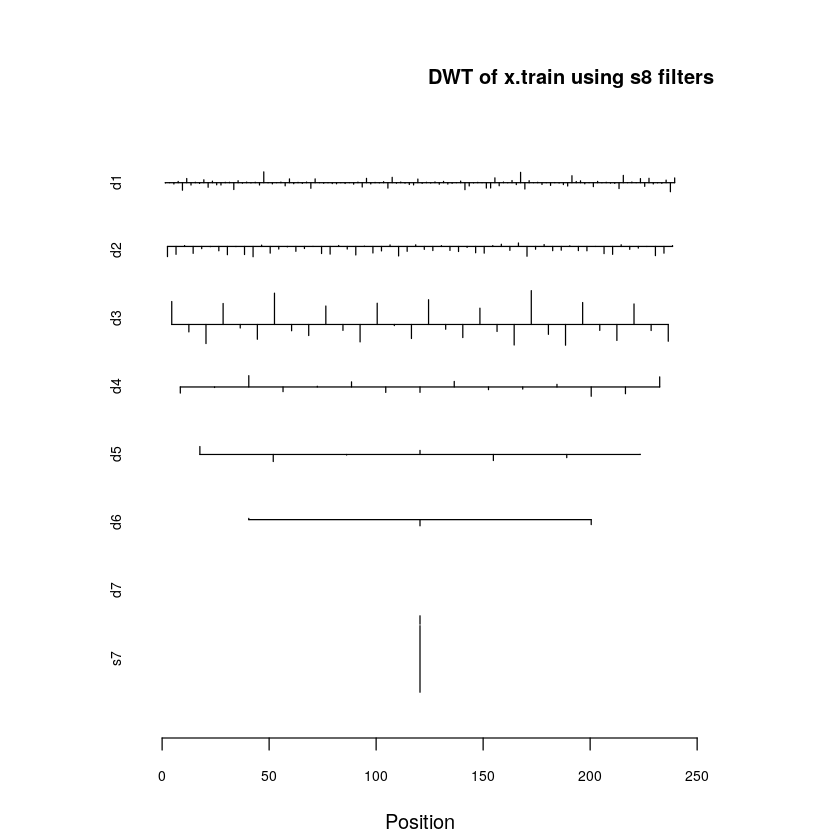

In [102]:
plot(ox.dwt.01)

In [119]:
x = x[1:128]

In [125]:
ywd <- wd(x, filter.number = 7)

In [142]:
x

[1]   4.14   2.44  27.41  52.53  35.98 148.22 189.71 219.83  88.19  32.56
 [11]   6.98   1.91   5.77   2.26  14.72  50.35  38.69  74.66 132.68 221.56
 [21]  96.89  21.21  24.26   2.21   4.35  22.34  42.14  24.88  44.10 109.95
 [31] 215.46 235.88  76.23  30.40   0.43   2.26   4.65   4.79  29.82  39.46
 [41] 118.77  52.36 150.27 205.62  65.50  23.16   4.18  53.28   3.34   1.52
 [51]  47.25  50.22  44.87  86.58 249.41 181.63 104.31  21.26   0.60   1.50
 [61]   3.54   2.99  13.49  33.53  87.67  81.33 153.72 235.03  75.23  32.08
 [71]  56.41   3.44   2.81   0.94  26.74  35.31  45.02  81.40 183.13 252.67
 [81]  57.97  13.91   0.07   5.43   1.36  19.82   5.34  94.36  68.71  80.45
 [91] 365.52 246.64  90.48  11.03   0.95  43.88   1.26   7.56  20.20  17.02
[101]  42.31 111.92 278.23 289.84 133.54  20.21   1.08   5.99   6.46   1.64
[111]  19.34  36.75  37.08  90.13 200.53 183.76 101.81  10.71  21.29  10.99
[121]   4.20   0.41  21.82  69.50  35.83 115.60 287.62 220.89

In [143]:
length(ywd$C)

[1] 255

In [130]:
W1 = t(GenW(filter.number = 7, family = "DaubExPhase"))

In [139]:
W1

[,1]        [,2]        [,3]        [,4]        [,5]        [,6]       
[1,]  0.35355339  0.35355339  0.35355339  0.35355339  0.35355339  0.35355339
[2,]  0.37996478 -0.03982212  0.08061261 -0.07130922 -0.22368247  0.14570764
[3,]  0.47021187 -0.74168309  0.37996478 -0.03982212  0.08061261 -0.07130922
[4,] -0.22368247  0.14570764  0.47021187 -0.74168309  0.37996478 -0.03982212
[5,]  0.08061261 -0.07130922 -0.22368247  0.14570764  0.47021187 -0.74168309
[6,] -0.66946788 -0.43757093  0.27786659  0.33997409  0.01972313  0.15858749
[7,]  0.01972313  0.15858749  0.37187816 -0.06099065 -0.66946788 -0.43757093
[8,]  0.06647622 -0.28352489 -0.48733163 -0.42154766 -0.06647622  0.28352489
     [,7]        [,8]       
[1,]  0.35355339  0.35355339
[2,]  0.47021187 -0.74168309
[3,] -0.22368247  0.14570764
[4,]  0.08061261 -0.07130922
[5,]  0.37996478 -0.03982212
[6,]  0.37187816 -0.06099065
[7,]  0.27786659  0.33997409
[8,]  0.48733163  0.42154766

In [134]:
class(W1)

[1] "matrix"

In [138]:
length(x)

[1] 128

In [67]:
A = WaveletForecast<-WaveletFittingarma(ts=x.train, Waveletlevels=floor(log(length(x.train))),
                                        boundary='periodic',FastFlag=TRUE, MaxARParam=2,
                                        MaxMAParam=2,NForecast=h)$Finalforecast

In [68]:
A <- ts(A, start = c(origin+n, 1), freq=f)

In [69]:
accuracy(A, x.test)

ME        RMSE     MAE      MPE       MAPE     ACF1      Theil's U
Test set -7.896437 59.47467 51.47681 -24203.09 24277.26 0.4875259 45.30005

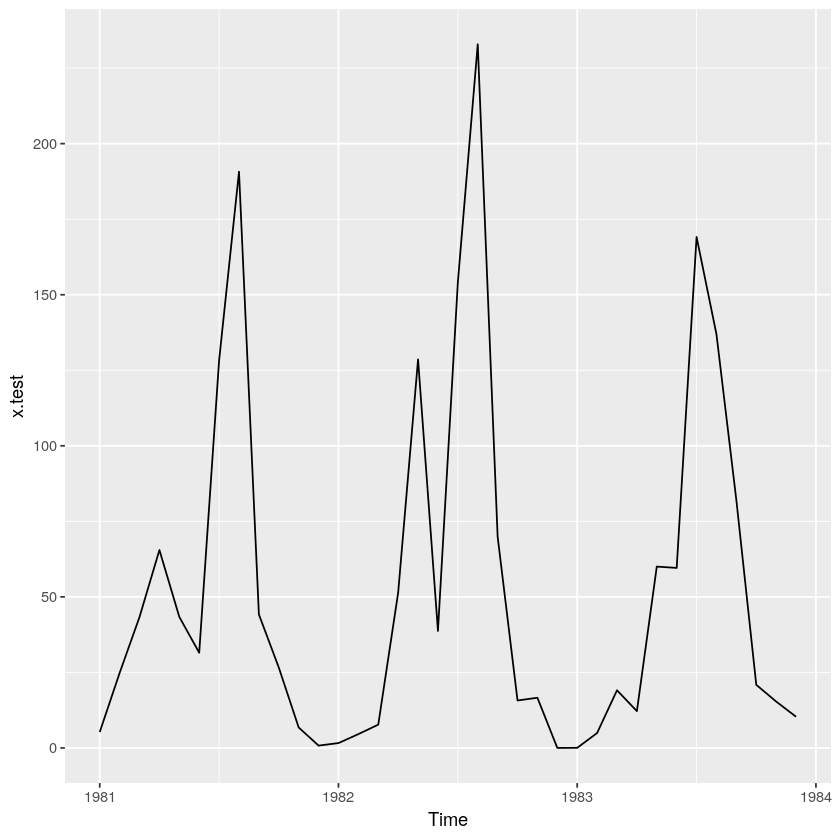

In [71]:
autoplot(x.test)

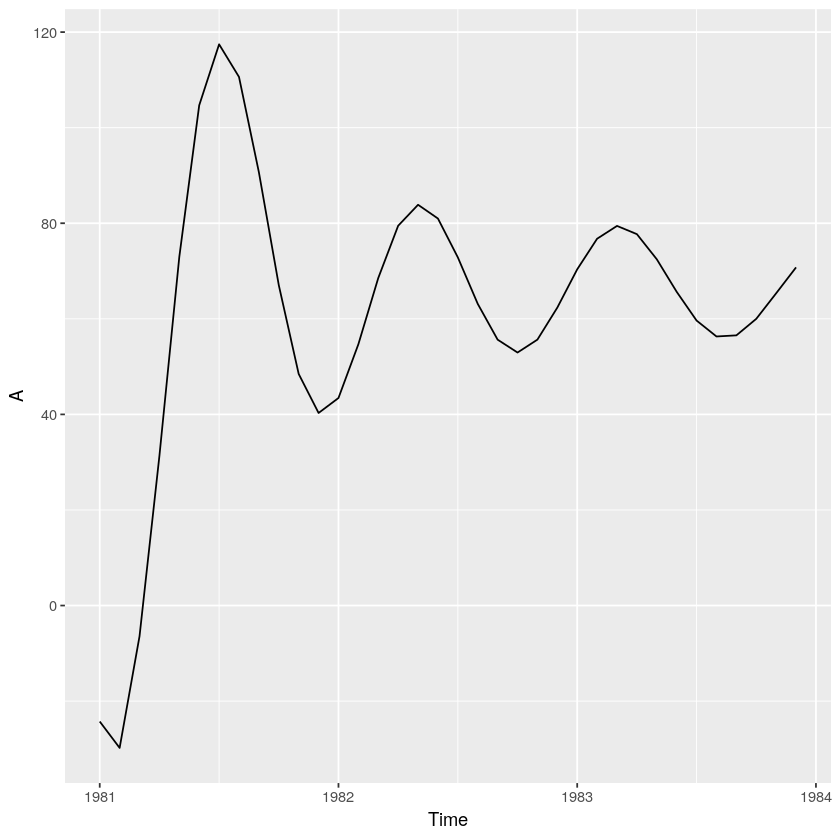

In [70]:
autoplot(A)

In [127]:
length(wt@series)

[1] 240

In [103]:
wt

DWT Wavelet Coefficients:
Level 1
Series 1: 2.1001e+00 3.0879e+01 -6.3534e+01 ... 1.0317e+01 -4.4654e+01 9.5813e+00
Level 2
Series 1: 2.6450e+01 1.0982e+02 -3.4515e+01 ... 1.1825e+01 1.2044e+02 -2.7500e+01
Level 3
Series 1: 1.7288e+02 -2.3349e+01 -1.0502e+02 ... 2.5226e+02 -1.5146e+01 -1.3244e+02
Level 4
Series 1: -1.2026e+02 2.6747e+01 1.9299e+02 ... -1.0829e+02 2.5275e+00 1.0103e+02
Level 5
Series 1: -1.9366e+01 1.1026e+02 1.3154e+01 ... 7.0145e+01 -4.0724e+01 -1.5344e+02
Level 6
Series 1: -7.1461e+01 -6.8750e+00 1.5754e+01
Level 7
Series 1: -3.7008e+00

DWT Scaling Coefficients:
Level 1
Series 1: 4.3770e+00 4.1783e+01 1.1831e+02 ... 2.5028e+02 5.2121e+01 1.3230e+01
Level 2
Series 1: 3.2640e+01 2.7713e+02 5.1135e+01 ... 2.8115e+01 2.3350e+02 4.6210e+01
Level 3
Series 1: 2.1904e+02 4.8967e+01 1.9591e+02 ... 2.8157e+02 5.4907e+01 1.9779e+02
Level 4
Series 1: 1.8951e+02 3.0381e+02 2.7643e+02 ... 2.4263e+02 3.9568e+02 1.7868e+02
Level 5
Series 1: 4.1029e+02 3.8366e+02 2.8260e+02 ... 3.93

In [13]:
wt<-dwt(x.train)

ERROR: Error in dwt(x.train): could not find function "dwt"


In [104]:
#wt.aligned <- align(wt)

In [105]:
#class(wt.aligned)

In [16]:
wt <- dwt(x.train,filter = "haar", boundary = "periodic")

In [40]:
length(wt@V$V2)

[1] 60

In [18]:
wtData <- NULL

In [107]:
length(wt@W)

[1] 7

In [48]:
wt

DWT Wavelet Coefficients:
Level 1
Series 1: 2.1001e+00 3.0879e+01 -6.3534e+01 ... 1.0317e+01 -4.4654e+01 9.5813e+00
Level 2
Series 1: 2.6450e+01 1.0982e+02 -3.4515e+01 ... 1.1825e+01 1.2044e+02 -2.7500e+01
Level 3
Series 1: 1.7288e+02 -2.3349e+01 -1.0502e+02 ... 2.5226e+02 -1.5146e+01 -1.3244e+02
Level 4
Series 1: -1.2026e+02 2.6747e+01 1.9299e+02 ... -1.0829e+02 2.5275e+00 1.0103e+02
Level 5
Series 1: -1.9366e+01 1.1026e+02 1.3154e+01 ... 7.0145e+01 -4.0724e+01 -1.5344e+02
Level 6
Series 1: -7.1461e+01 -6.8750e+00 1.5754e+01
Level 7
Series 1: -3.7008e+00

DWT Scaling Coefficients:
Level 1
Series 1: 4.3770e+00 4.1783e+01 1.1831e+02 ... 2.5028e+02 5.2121e+01 1.3230e+01
Level 2
Series 1: 3.2640e+01 2.7713e+02 5.1135e+01 ... 2.8115e+01 2.3350e+02 4.6210e+01
Level 3
Series 1: 2.1904e+02 4.8967e+01 1.9591e+02 ... 2.8157e+02 5.4907e+01 1.9779e+02
Level 4
Series 1: 1.8951e+02 3.0381e+02 2.7643e+02 ... 2.4263e+02 3.9568e+02 1.7868e+02
Level 5
Series 1: 4.1029e+02 3.8366e+02 2.8260e+02 ... 3.93

In [55]:
length(wt@V$V1)

[1] 120

In [19]:
wtData <- rbind(wtData, unlist(c(wt@W,wt@V[[wt@level]])))

In [20]:
wtData <- as.data.frame(wtData)

In [114]:
wtData$

W11      W12      W13       W14      W15      W16       W17      W18      
1 2.100107 30.87935 -63.53355 55.73416 -38.3464 -11.73797 3.471894 -4.879037
  W19       W110      ⋯ W53      W54       W55      W56       W57      
1 -0.311126 -22.79005 ⋯ 13.15395 -59.91316 70.14499 -40.72404 -153.4386
  W61       W62       W63      W7       V237    
1 -71.46125 -6.874999 15.75375 -3.70082 793.6894

# SEAS

In [7]:
load("data.RData")
load("lat.RData")
load("lon.RData")

x<-data[4,5,]

x.ts<-ts(x, start = c(1946, 1), freq=f)

x <- fuzzify(x)

n=20
# Set forecasting window length (in years)
m=3
# Set start year
start = 1946
origin = 1982
# Set annual sampling rate
f = 12
h = m*f

index = (origin - (start - 1)) * 12 +1

x.ts <- x[index:length(x)-1]
#x.ts<-x
train_start = index
train_end = train_start+n*f-1

test_start = train_end + 1
test_end = test_start + m*f -1

x.train <- x[train_start:train_end]
x.test <- x[test_start:test_end]

x.ts = ts(x, start=c(origin, 1), freq=f)


x.train <- ts(x.train, start = c(origin, 1), freq=f)
x.test <- ts(x.test, start = c(origin+n, 1), freq=f)

In [36]:
x.train %>% seas(x11="") -> fit

In [49]:
fit$series

$d10
            Jan        Feb        Mar        Apr        May        Jun
1982 2.38904564 1.55591837 0.95552546 0.59558209 0.29711217 0.11859348
1983 2.44590474 1.68488709 0.96523145 0.54549921 0.27295269 0.10765091
1984 2.30580903 1.85911826 0.97624822 0.49891646 0.26347668 0.09662342
1985 2.10952581 1.94106440 1.02831669 0.45322467 0.25604122 0.08665181
1986 1.95911913 1.93770351 1.07202205 0.40950473 0.24802376 0.08300236
1987 1.77700887 1.98800623 1.22368809 0.36890990 0.23398253 0.07807890
1988 1.65457211 1.96055161 1.37741046 0.35488507 0.21798357 0.06803118
1989 1.45528710 1.91934534 1.67584456 0.37183293 0.20306333 0.05361145
1990 1.24404711 1.87800650 1.93181595 0.39842976 0.18969835 0.04442897
1991 1.13927771 1.75737884 2.14236080 0.45200377 0.18553782 0.04517080
1992 1.18413166 1.56917326 2.22337673 0.51206958 0.19249036 0.05134353
1993 1.40003681 1.35035587 2.25863603 0.57138316 0.18126322 0.05322919
1994 1.60277869 1.18451454 2.22696173 0.65151917 0.17527491 0.05354260
1

In [48]:
fit$data[,2]

            Jan        Feb        Mar        Apr        May        Jun
1982 2.38904564 1.55591837 0.95552546 0.59558209 0.29711217 0.11859348
1983 2.44590474 1.68488709 0.96523145 0.54549921 0.27295269 0.10765091
1984 2.30580903 1.85911826 0.97624822 0.49891646 0.26347668 0.09662342
1985 2.10952581 1.94106440 1.02831669 0.45322467 0.25604122 0.08665181
1986 1.95911913 1.93770351 1.07202205 0.40950473 0.24802376 0.08300236
1987 1.77700887 1.98800623 1.22368809 0.36890990 0.23398253 0.07807890
1988 1.65457211 1.96055161 1.37741046 0.35488507 0.21798357 0.06803118
1989 1.45528710 1.91934534 1.67584456 0.37183293 0.20306333 0.05361145
1990 1.24404711 1.87800650 1.93181595 0.39842976 0.18969835 0.04442897
1991 1.13927771 1.75737884 2.14236080 0.45200377 0.18553782 0.04517080
1992 1.18413166 1.56917326 2.22337673 0.51206958 0.19249036 0.05134353
1993 1.40003681 1.35035587 2.25863603 0.57138316 0.18126322 0.05322919
1994 1.60277869 1.18451454 2.22696173 0.65151917 0.17527491 0.05354260
1995 1

In [47]:
x.train

              Jan          Feb          Mar          Apr          May
1982   5.59568388  43.69568474  19.97568352   6.77568419   3.84568388
1983  60.89568551   9.97568352  67.45568306  11.10568364   7.60568411
1984  79.86568673  33.97568352   9.01568444  26.53568489  14.57568390
1985  72.18568642  57.55568535  37.78568489  30.05568345   5.85568411
1986  56.48568566   8.89568360  52.86568291   2.45568402   0.74568398
1987  64.46568520 118.08568032  35.38568337   1.96568401   5.82568390
1988  26.09568436 110.00568612  24.15568383   8.35568364   4.49568398
1989  24.68568451   0.05568398  52.13568337  33.99568398  13.55568440
1990   7.83568413  76.59568245  60.02568276   3.21568401   3.99568398
1991   4.28568394  31.35568459  10.46568425   1.96568401   0.67568399
1992  13.90568383  22.76568444 106.14568551   5.94568379  10.10568364
1993  46.36568291   2.24568398  39.06568367  22.60568459   4.78568394
1994   1.02568395   7.19568379  43.44568474  15.12568409   0.04568398
1995 105.09568245  6

In [41]:
x.train

              Jan          Feb          Mar          Apr          May
1982   5.59568388  43.69568474  19.97568352   6.77568419   3.84568388
1983  60.89568551   9.97568352  67.45568306  11.10568364   7.60568411
1984  79.86568673  33.97568352   9.01568444  26.53568489  14.57568390
1985  72.18568642  57.55568535  37.78568489  30.05568345   5.85568411
1986  56.48568566   8.89568360  52.86568291   2.45568402   0.74568398
1987  64.46568520 118.08568032  35.38568337   1.96568401   5.82568390
1988  26.09568436 110.00568612  24.15568383   8.35568364   4.49568398
1989  24.68568451   0.05568398  52.13568337  33.99568398  13.55568440
1990   7.83568413  76.59568245  60.02568276   3.21568401   3.99568398
1991   4.28568394  31.35568459  10.46568425   1.96568401   0.67568399
1992  13.90568383  22.76568444 106.14568551   5.94568379  10.10568364
1993  46.36568291   2.24568398  39.06568367  22.60568459   4.78568394
1994   1.02568395   7.19568379  43.44568474  15.12568409   0.04568398
1995 105.09568245  6

In [15]:
d = seas(x.train)

In [35]:
d$data

final      seasonal   seasonaladj trend    irregular  adjustfac 
 [1,]   3.341977 1.67436336   3.341977  31.17214 0.10721037 1.67436336
 [2,]  38.814093 1.12576854  38.814093  31.17217 1.24515224 1.12576854
 [3,]  12.082477 1.65327717  12.082477  31.17219 0.38760436 1.65327717
 [4,]  10.872807 0.62317711  10.872807  31.17222 0.34879799 0.62317711
 [5,]  21.774348 0.17661534  21.774348  31.17225 0.69851707 0.17661534
 [6,]  11.477170 0.06409977  11.477170  31.17228 0.36818511 0.06409977
 [7,]  32.321418 0.03173388  32.321418  31.17232 1.03686290 0.03173388
 [8,]  45.115563 0.03470386  45.115563  31.17234 1.44729474 0.03470386
 [9,]   4.978766 0.24216522   4.978766  31.17236 0.15971735 0.24216522
[10,]   7.682135 0.71668669   7.682135  31.17239 0.24644041 0.71668669
[11,]  60.216752 2.08722128  60.216752  31.17242 1.93173154 2.08722128
[12,]   8.067668 3.56926994   8.067668  31.17246 0.25880758 3.56926994
[13,]  36.364584 1.67458772  36.364584  31.17248 1.16656032 1.67458772
[14,]   8.861938 1.12567741   8.861938  31.17251 0.28428692 1.12567741
[15,]  40.800630 1.65330003  40.800630  31.17254 1.30886440 1.65330003
[16,]  17.820522 0.62319630  17.820522  31.17256 0.57167331 0.62319630
[17,]  43.065289 0.17660822  43.065289  31.17257 1.38151208 0.17660822
[18,]  38.309531 0.06410112  38.309531  31.17257 1.22894998 0.06410112
[19,]   2.069938 0.03173234   2.069938  31.17257 0.06640256 0.03173234
[20,]  96.417436 0.03469999  96.417436  31.17257 3.09302172 0.03469999
[21,] 172.576340 0.24218664 172.576340  31.17255 5.53616302 0.24218664
[22,]   7.290882 0.71674239   7.290882  31.17251 0.23388820 0.71674239
[23,]  25.652354 2.08696965  25.652354  31.17246 0.82291732 2.08696965
[24,]  38.320673 3.56950094  38.320673  31.17240 1.22931413 3.56950094
[25,]  47.688351 1.67474207  47.688351  31.17233 1.52982958 1.67474207
[26,]  30.182953 1.12565803  30.182953  31.17224 0.96826392 1.12565803
[27,]   5.453265 1.65326373   5.453265  31.17214 0.17494032 1.65326373
[28,]  42.577790 0.62322833  42.577790  31.17205 1.36589638 0.62322833
[29,]  82.539616 0.17659016  82.539616  31.17195 2.64788143 0.17659016
[30,]  90.260801 0.06409963  90.260801  31.17181 2.89559061 0.06409963
[31,] ⋮          ⋮          ⋮           ⋮        ⋮          ⋮         
[32,]  16.813297 0.03186074  16.813297  31.13561 0.54000208 0.03186074
[33,]  52.831325 0.03474613  52.831325  31.13570 1.69680860 0.03474613
[34,]   7.913625 0.24207413   7.913625  31.13578 0.25416500 0.24207413
[35,]  24.611702 0.71818211  24.611702  31.13586 0.79046169 0.71818211
[36,]   5.282627 2.08148035   5.282627  31.13594 0.16966330 2.08148035
[37,]  15.447037 3.57645841  15.447037  31.13604 0.49611438 3.57645841
[38,]   5.482629 1.67723988   5.482629  31.13615 0.17608564 1.67723988
[39,]   1.692036 1.12035699   1.692036  31.13629 0.05434289 1.12035699
[40,]  17.054940 1.65088141  17.054940  31.13645 0.54774834 1.65088141
[41,]  31.626329 0.62592416  31.626329  31.13663 1.01572742 0.62592416
[42,]   2.928957 0.17606400   2.928957  31.13681 0.09406736 0.17606400
[43,]   1.184369 0.06390239   1.184369  31.13702 0.03803731 0.06390239
[44,]  21.831709 0.03186576  21.831709  31.13727 0.70114400 0.03186576
[45,]  15.125776 0.03475418  15.125776  31.13753 0.48577318 0.03475418
[46,]  23.037963 0.24202156  23.037963  31.13779 0.73987155 0.24202156
[47,]  24.554530 0.71822525  24.554530  31.13804 0.78857012 0.71822525
[48,]  44.402745 2.08153089  44.402745  31.13829 1.42598549 2.08153089
[49,]  21.345677 3.57663434  21.345677  31.13852 0.68550720 3.57663434
[50,]  32.379109 1.67718282  32.379109  31.13874 1.03983377 1.67718282
[51,]  17.144272 1.12023906  17.144272  31.13895 0.55057327 1.12023906
[52,]  36.372518 1.65085310  36.372518  31.13915 1.16806390 1.65085310
[53,]  63.928012 0.62594914  63.928012  31.13934 2.05296628 0.62594914
[54,]  53.648939 0.17606469  53.648939  31.13950 1.72285796 0.17606469
[55,]  47.818572 0.06390161  47.818572  31.13964 1.53561735 0.06390161
[56,] 110.945046 0.03186879 11

In [39]:
x.train

              Jan          Feb          Mar          Apr          May
1982   5.59568388  43.69568474  19.97568352   6.77568419   3.84568388
1983  60.89568551   9.97568352  67.45568306  11.10568364   7.60568411
1984  79.86568673  33.97568352   9.01568444  26.53568489  14.57568390
1985  72.18568642  57.55568535  37.78568489  30.05568345   5.85568411
1986  56.48568566   8.89568360  52.86568291   2.45568402   0.74568398
1987  64.46568520 118.08568032  35.38568337   1.96568401   5.82568390
1988  26.09568436 110.00568612  24.15568383   8.35568364   4.49568398
1989  24.68568451   0.05568398  52.13568337  33.99568398  13.55568440
1990   7.83568413  76.59568245  60.02568276   3.21568401   3.99568398
1991   4.28568394  31.35568459  10.46568425   1.96568401   0.67568399
1992  13.90568383  22.76568444 106.14568551   5.94568379  10.10568364
1993  46.36568291   2.24568398  39.06568367  22.60568459   4.78568394
1994   1.02568395   7.19568379  43.44568474  15.12568409   0.04568398
1995 105.09568245  6

# TBATS

In [57]:
load("data.RData")
load("lat.RData")
load("lon.RData")

In [58]:
x<-data[4,5,]

x.ts<-ts(x, start = c(1946, 1), freq=f)

In [59]:
x <- fuzzify(x)

In [60]:
n=20
# Set forecasting window length (in years)
m=3
# Set start year
start = 1946
origin = 1982
# Set annual sampling rate
f = 12
h = m*f

In [61]:
index = (origin - (start - 1)) * 12 +1

In [62]:
x.ts <- x[index:length(x)-1]
#x.ts<-x
train_start = index
train_end = train_start+n*f-1

test_start = train_end + 1
test_end = test_start + m*f -1

x.train <- x[train_start:train_end]
x.test <- x[test_start:test_end]

In [75]:
x.ts = ts(x, start=c(origin, 1), freq=f)

In [63]:

x.train <- ts(x.train, start = c(origin, 1), freq=f)
x.test <- ts(x.test, start = c(origin+n, 1), freq=f)

In [64]:
A = forecast(tbats(x.train),h=h)$mean

In [65]:
accuracy(A, x.test)

ME       RMSE     MAE      MPE       MAPE     ACF1        Theil's U
Test set 10.78352 30.67121 17.23018 -229.2482 291.3463 -0.05665548 0.8803526

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


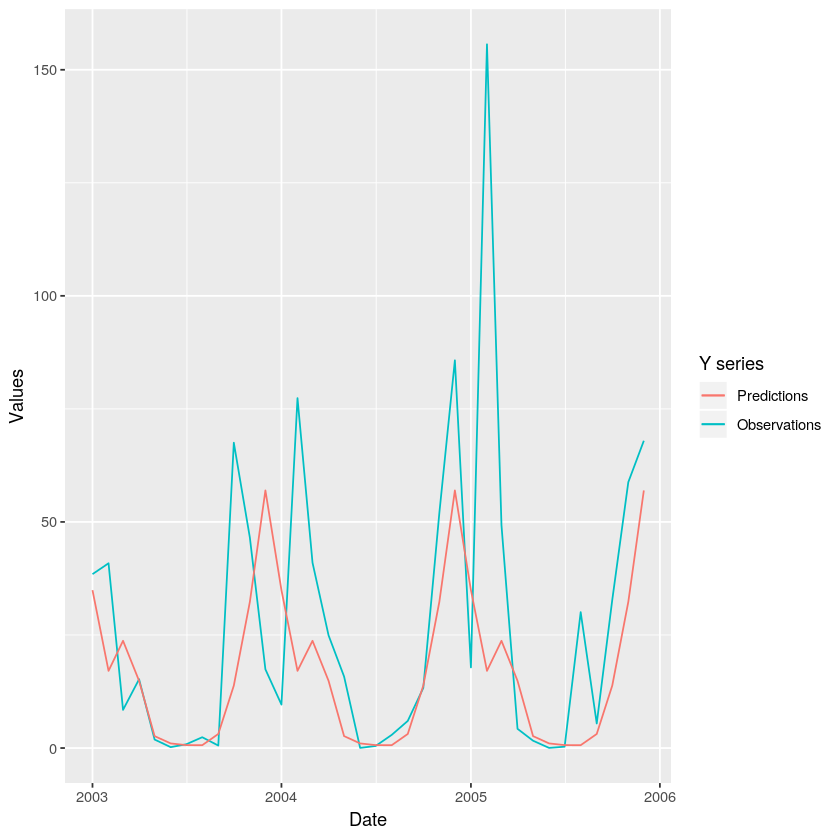

In [66]:
data <- data.frame(
  date = seq(as.Date("2003/1/1"), by = "month", length.out = 36),
  x.test,
  A
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test,colour="red") ) +  # first layer
  geom_line(aes(y=A,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

In [67]:
pa = phase_average(x.train, 12)
x.train.t <- ts(pa$result, start = c(origin, 1), freq=f)

In [68]:
APA = forecast(auto.arima(x.train.t),h=h)$mean
APA = inv_phase_average(APA, f, pa$averages, pa$stds)

In [69]:
accuracy(APA, x.test)

ME        RMSE     MAE      MPE       MAPE     ACF1        Theil's U
Test set 0.5412797 27.67957 15.07992 -573.1892 602.3065 -0.09712189 0.7778386

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


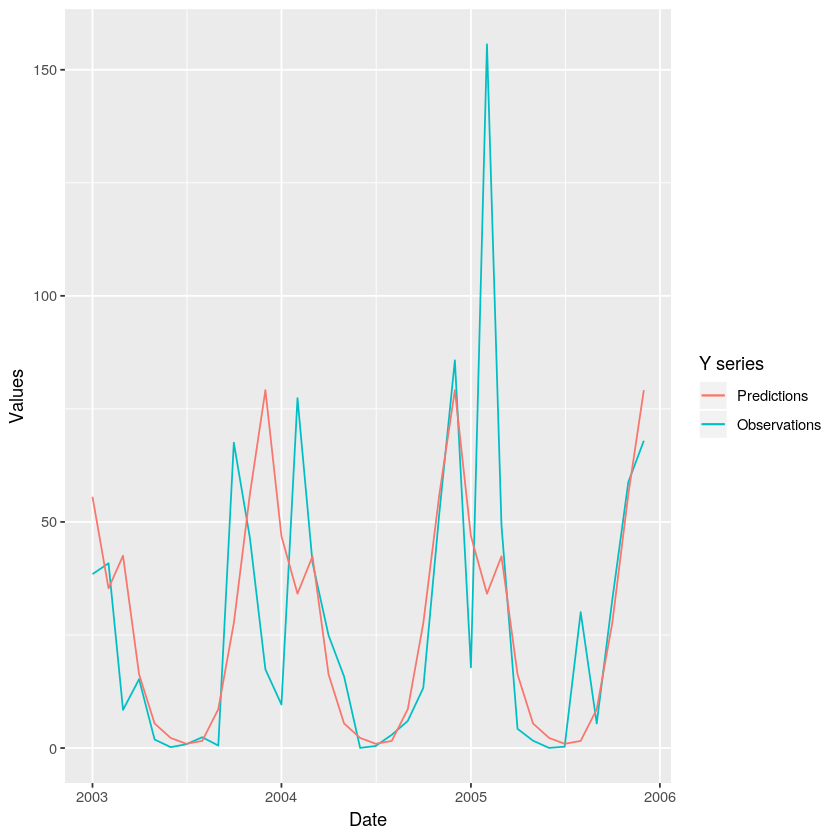

In [71]:
data <- data.frame(
  date = seq(as.Date("2003/1/1"), by = "month", length.out = 36),
  x.test,
  APA
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test,colour="red") ) +  # first layer
  geom_line(aes(y=APA,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

In [84]:
 calls <- unlist(read.csv("https://robjhyndman.com/data/callcenter.txt",
                      header=TRUE,sep="\t")[,-1])
    calls <- msts(calls, start=1, seasonal.periods = c(169, 169*5))

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


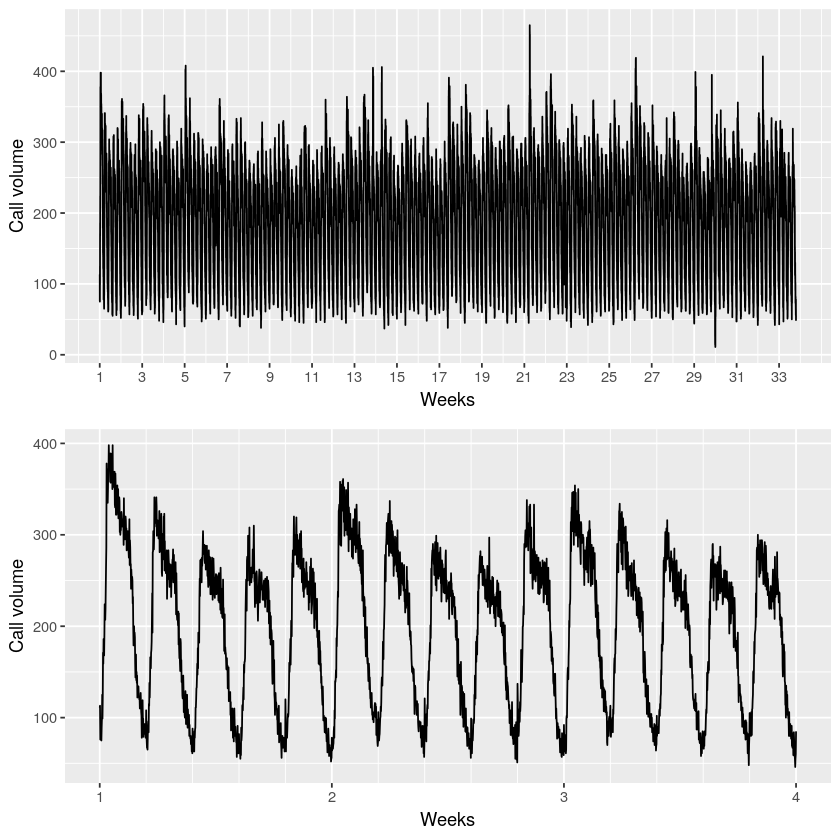

In [85]:
p1 <- autoplot(calls) +
  ylab("Call volume") + xlab("Weeks") +
  scale_x_continuous(breaks=seq(1,33,by=2))
p2 <- autoplot(window(calls, end=4)) +
  ylab("Call volume") + xlab("Weeks") +
  scale_x_continuous(minor_breaks = seq(1,4,by=0.2))
gridExtra::grid.arrange(p1,p2)

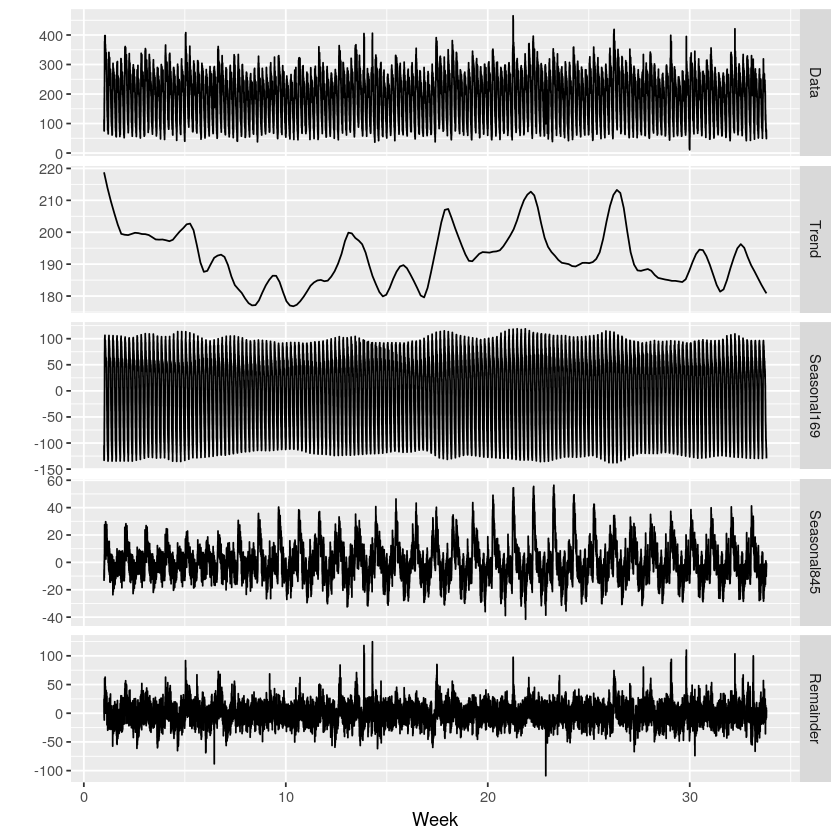

In [86]:
calls %>% mstl() %>%
  autoplot() + xlab("Week")

In [95]:
calls

Multi-Seasonal Time Series:
Start: 1 1
Seasonal Periods: 169 845
Data:
    X3.3.20031     X3.3.20032     X3.3.20033     X3.3.20034     X3.3.20035 
           111            113             76             82             91 
    X3.3.20036     X3.3.20037     X3.3.20038     X3.3.20039    X3.3.200310 
            87             75             89             99            125 
   X3.3.200311    X3.3.200312    X3.3.200313    X3.3.200314    X3.3.200315 
            99            122            171            159            186 
   X3.3.200316    X3.3.200317    X3.3.200318    X3.3.200319    X3.3.200320 
           175            168            191            224            212 
   X3.3.200321    X3.3.200322    X3.3.200323    X3.3.200324    X3.3.200325 
           207            219            243            266            286 
   X3.3.200326    X3.3.200327    X3.3.200328    X3.3.200329    X3.3.200330 
           378            344            366            364            335 
   X3.3.200331   

In [82]:
stl(x.train,s.window="periodic")

 Call:
 stl(x = x.train, s.window = "periodic")

Components
           seasonal     trend   remainder
Jan 1982  21.038991 10.100295 -25.5417879
Feb 1982   8.189322 12.123891  23.3842858
Mar 1982  16.316640 14.147487 -10.4866295
Apr 1982  -9.954879 16.034336   0.6980414
May 1982 -20.998375 17.921185   6.9246887
Jun 1982 -24.413051 19.703113   5.4474356
Jul 1982 -25.924727 21.485042   5.4671830
Aug 1982 -25.491077 23.108480   3.9500947
Sep 1982 -18.675922 24.731918  -4.8484975
Oct 1982   0.157625 25.575455 -20.2255822
Nov 1982  28.437641 26.418993  70.8308669
Dec 1982  51.317811 26.774278 -49.2945918
Jan 1983  21.038991 27.129563  12.7289465
Feb 1983   8.189322 27.542754 -25.7545787
Mar 1983  16.316640 27.955946  23.1849107
Apr 1983  -9.954879 28.512037  -7.4496601
May 1983 -20.998375 29.068127  -0.4622538
Jun 1983 -24.413051 30.652161  -3.7816121
Jul 1983 -25.924727 32.236195  -6.2439698
Aug 1983 -25.491077 33.398814  -4.5602391
Sep 1983 -18.675922 34.561432  25.9119871
Oct 1983   0.157

             Jan         Feb         Mar         Apr         May         Jun
1982   5.5974980  43.6974989  19.9774976   6.7774983   3.8474980   0.7374981
1983  60.8974996   9.9774976  67.4574972  11.1074978   7.6074982   2.4574981
1984  79.8675008  33.9774976   9.0174986  26.5374990  14.5774980   5.7874981
1985  72.1875005  57.5574995  37.7874990  30.0574976   5.8574982   5.0874982
1986  56.4874998   8.8974977  52.8674970   2.4574981   0.7474981   0.4074981
1987  64.4674993 118.0874944  35.3874975   1.9674981   5.8274980   5.1574979
1988  26.0974985 110.0075002  24.1574979   8.3574978   4.4974981   0.1174981
1989  24.6874986   0.0574981  52.1374975  33.9974981  13.5574985   1.3574981
1990   7.8374982  76.5974966  60.0274969   3.2174981   3.9974981   0.9874981
1991   4.2874981  31.3574987  10.4674984   1.9674981   0.6774981   4.5074983
1992  13.9074979  22.7674986 106.1474996   5.9474979  10.1074978   0.9574981
1993  46.3674970   2.2474981  39.0674978  22.6074987   4.7874981   0.1574981

In [9]:
lambda <- BoxCox.lambda(x.train)

In [172]:
x.train.t <- BoxCox(x.train, lambda)

In [206]:
m = mean(x.train.t)
s = sd(x.train.t)

In [207]:
x.train.t = (x.train.t - m)/s

In [79]:
pa = phase_average(x.train, 12)
x.train.t <- ts(pa$result, start = c(origin, 1), freq=f)

In [92]:
A = auto.arima(x.train.t)
freq <- frequency(residuals(A))

lag <- ifelse(freq > 1, 2 * freq, 10)
lag <- min(lag, round(length(residuals)/5))
lag <- max(df+3, lag)
df = length(A$coef)
t = Box.test(residuals(A),fitdf = df,lag = lag,type="Ljung")

t$p.value

[1] 0.30812

In [98]:
A = ets(x.train.t)
freq <- frequency(residuals(A))

lag <- ifelse(freq > 1, 2 * freq, 10)
lag <- min(lag, round(length(residuals)/5))
lag <- max(df+3, lag)

df = length(A$par)
t = Box.test(residuals(A),fitdf = df,lag = lag,type="Ljung")

t$p.value

[1] 0.04126296

In [101]:
lag

[1] 5

In [121]:
load("P.Rdata")

In [123]:
P

[,1] [,2] [,3]      [,4]       [,5]       [,6]       [,7]       
 [1,] NA   NA          NA         NA         NA         NA 0.041776451
 [2,] NA   NA          NA         NA         NA         NA 0.198651576
 [3,] NA   NA          NA 0.02136002         NA         NA 0.003134244
 [4,] NA   NA          NA 0.10362129         NA         NA 0.261958112
 [5,] NA   NA   0.2143642 0.10306457 0.03676971 0.03612818 0.359169360
 [6,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
 [7,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
 [8,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
 [9,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[10,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[11,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[12,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[13,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[14,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[15,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[16,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[17,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[18,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[19,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[20,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[21,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[22,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[23,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[24,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[25,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[26,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[27,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[28,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[29,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[30,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[31,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
[32,]  0    0   0.0000000 0.00000000 0.00000000 0.00000000 0.000000000
      [,8]        [,9]        [,10]     [,11] [,12]      [,13]     [,14]      
 [1,] 0.013035878 0.043352481 0.2679968 ⋯     0.26724338 0.1932152 0.392731577
 [2,] 0.007154856 0.075577225 0.2079953 ⋯     0.18682060 0.5188424 0.468286418
 [3,] 0.028674001 0.015399809 0.3027198 ⋯     0.06628067 0.2117607 0.003407326
 [4,] 0.170657837 0.003163734 0.1101227 ⋯     0.98663103 0.1073332 0.026623442
 [5,] 0.273774039 0.698198659 0.6980345 ⋯     0.15306564 0.4260035 0.250052888
 [6,] 0.000000000 0.000000000 0.0000000 ⋯     0.00000000 0.0000000 0.000000000
 [7,] 0.000000000 0.000000000 0.0000000 ⋯     0.00000000 0.0000000 0.000000000
 [8,] 0.000000000 0.000000000 0.0000000 ⋯     0.00000000 0.0000000 0.000000000
 [9,] 0.000000000 0.000000000 0.0000000 ⋯     0.00000000 0.0000000 0.000000000
[10,] 0.000000000 0.000000000 0.0000000 ⋯     0.00000000 0.0000000 0.000000000
[11,] 0.000000000 0.000000000 0.0000000 ⋯     0.00000000 0.0000000 0.000000000
[12,] 0.000000000 0.000000000 0.0000000 ⋯     0.00000000 0.0000000 0.000000000
[13,] 0.000000000 0.000000000 0.0000000 ⋯     0.00000000 0.0000000 0.000000000
[14,] 0.000000000 0.000000000 0.0000000 ⋯     0.00000000 0.0000000 0.000000000
[15,] 0.000000000 0.000000000 0.0000000 ⋯     0.00000000 0.0000000 0.000000000
[16,] 0.000000000 0.000000000 0.0000000 ⋯     0.00000000 0.0000000 0.000000000
[17,] 0.000000000 0.000000000 0.0000000 ⋯     0.00000000 0.0000000 0.000000000
[18,] 0.000000000 0.000000000 0.0000000 ⋯     0.00000000 0.0000000 0.000000000
[19,] 0.000000000 0.000000000 0.0000000 ⋯     0.00000000 0.0000000 0.000000000
[20,] 0.000000000 0.000000000 0.0000000 ⋯     0.00000000 0.0000000 0.000000000
[21,

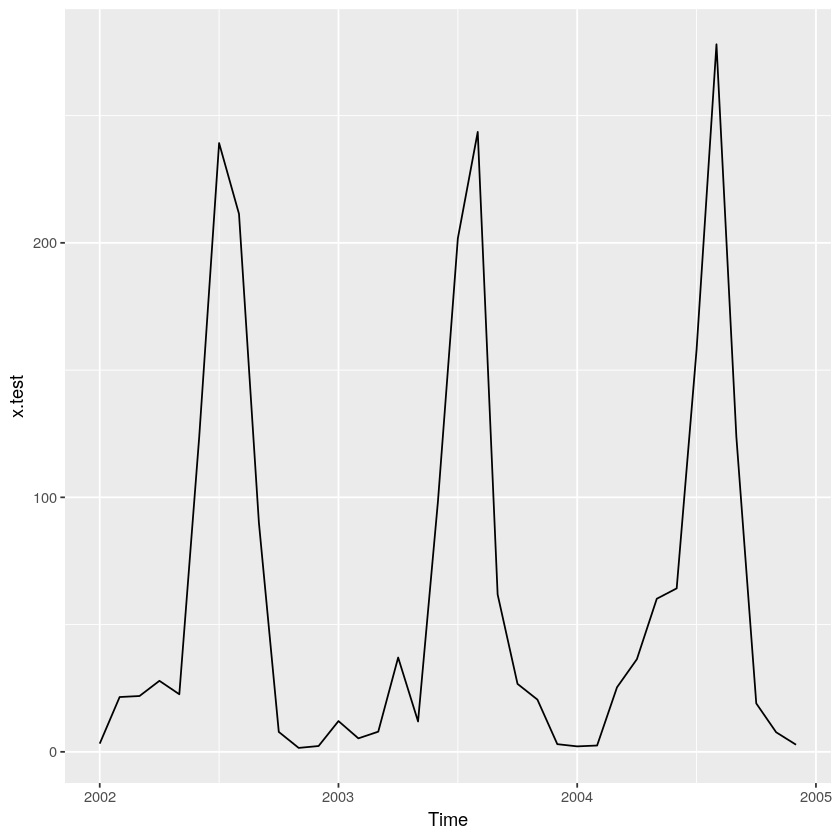

In [90]:
autoplot(x.test)

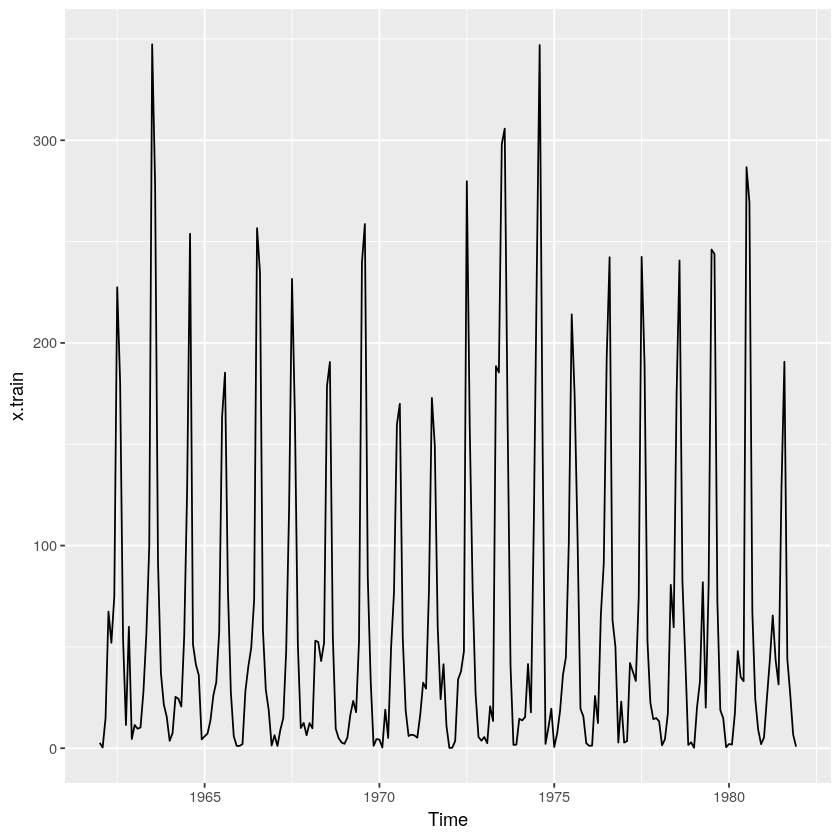

In [175]:
autoplot(x.train)

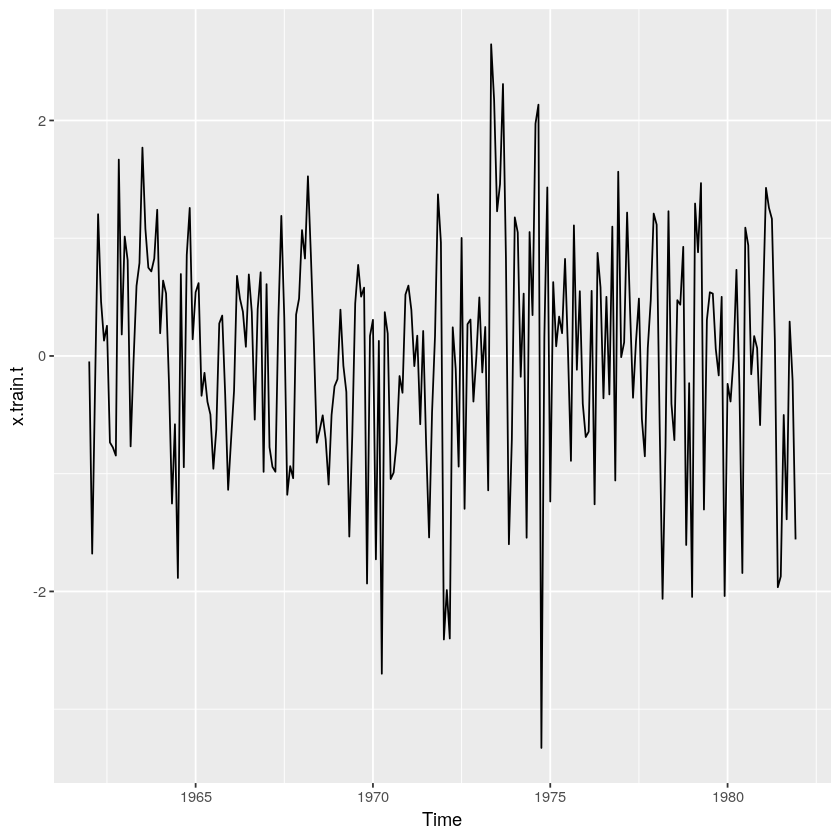

In [176]:
autoplot(x.train.t)

In [ ]:
invSTL(x,seaons)

In [63]:
s = stl(x.train, robust = TRUE, s.window = "periodic")
seasons = s$time.series[,1][seq(1,12)]
x.train.t = seasadj(s)

In [64]:
A = forecast(auto.arima(x.train.t),h=h,biasadj=TRUE)$mean

In [65]:
A = A + seasons

In [66]:
accuracy(A, x.test)

ME        RMSE     MAE      MPE       MAPE     ACF1      Theil's U
Test set -1.746167 12.28683 8.259325 -1390.516 1403.912 0.1149338 2.334345

In [53]:
accuracy(A, x.test)[2]/mean(x.test)

[1] 0.6783203

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


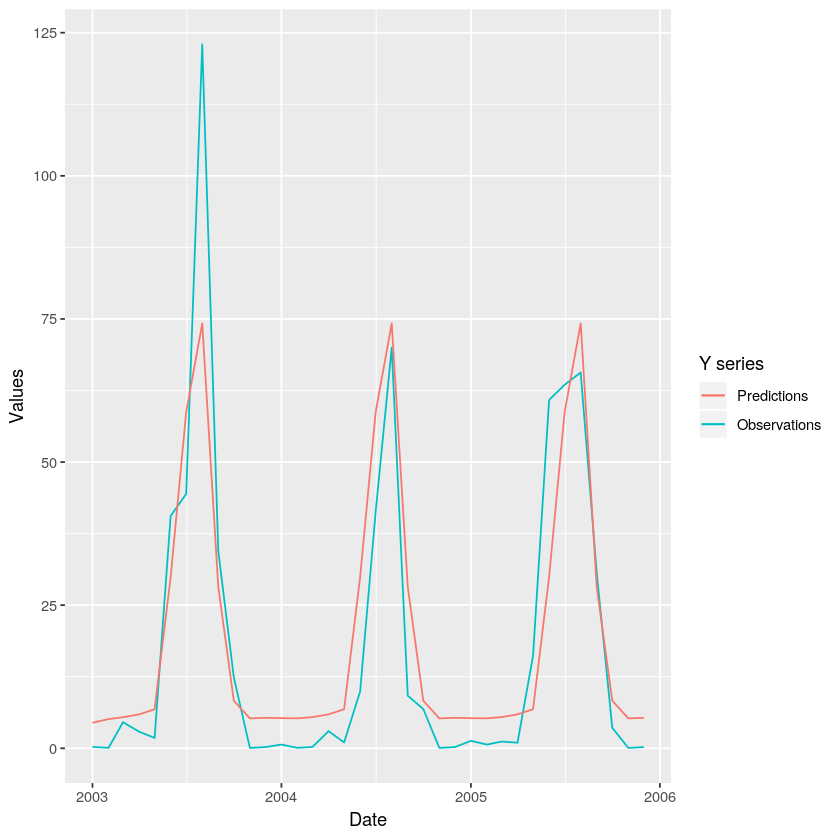

In [54]:
data <- data.frame(
  date = seq(as.Date("2003/1/1"), by = "month", length.out = 36),
  x.test,
  A
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test,colour="red") ) +  # first layer
  geom_line(aes(y=A,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

In [146]:
dec = decompose(x.train)

In [147]:
seasons = dec$seasonal[seq(1:12)]

In [149]:
x.train.t = seasadj(dec)

In [150]:
A = forecast(auto.arima(x.train.t),h)$mean

In [151]:
A = A + seasons

accuracy(A, x.test)

ME        RMSE     MAE      MPE       MAPE     ACF1      Theil's U
Test set -6.082037 31.50614 19.34573 -2531.053 2555.216 0.2805524 3.105425

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


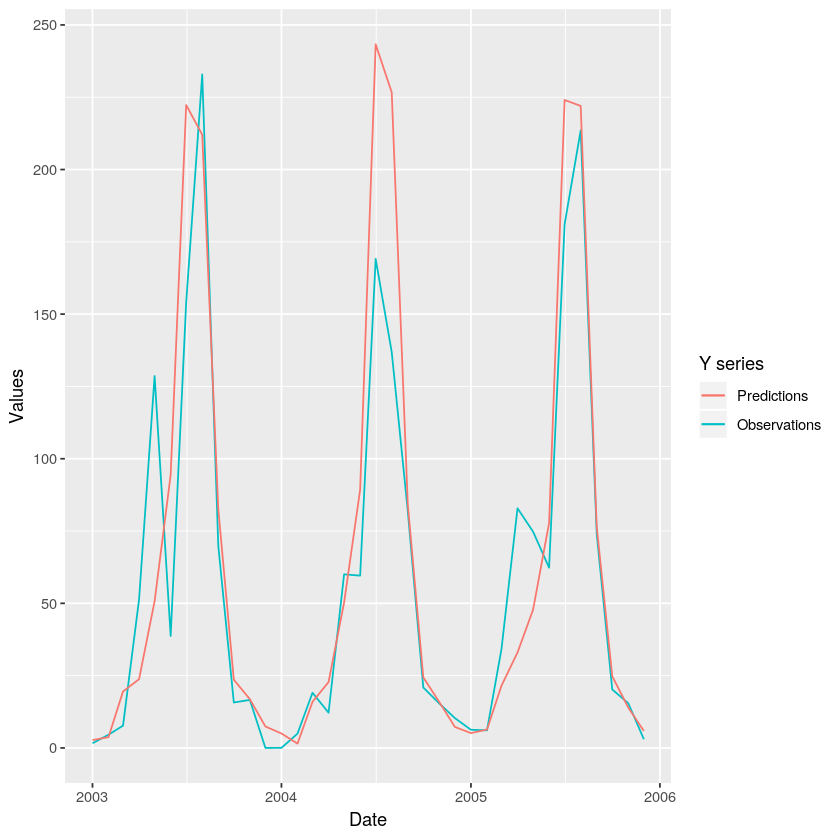

In [152]:
data <- data.frame(
  date = seq(as.Date("2003/1/1"), by = "month", length.out = 36),
  x.test,
  A
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test,colour="red") ) +  # first layer
  geom_line(aes(y=A,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

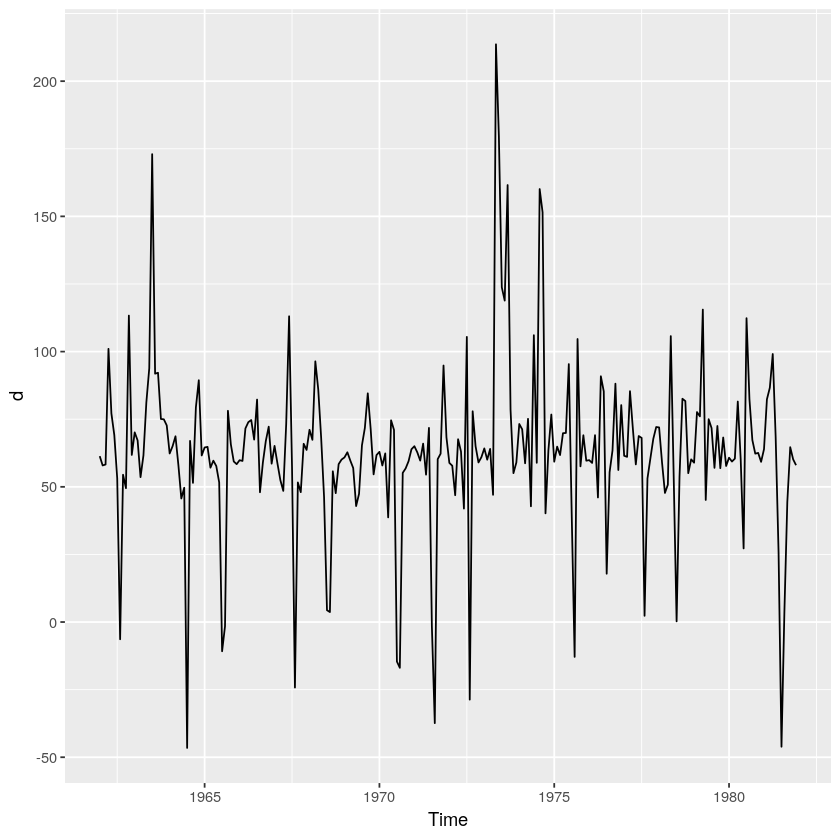

In [75]:
autoplot(d)

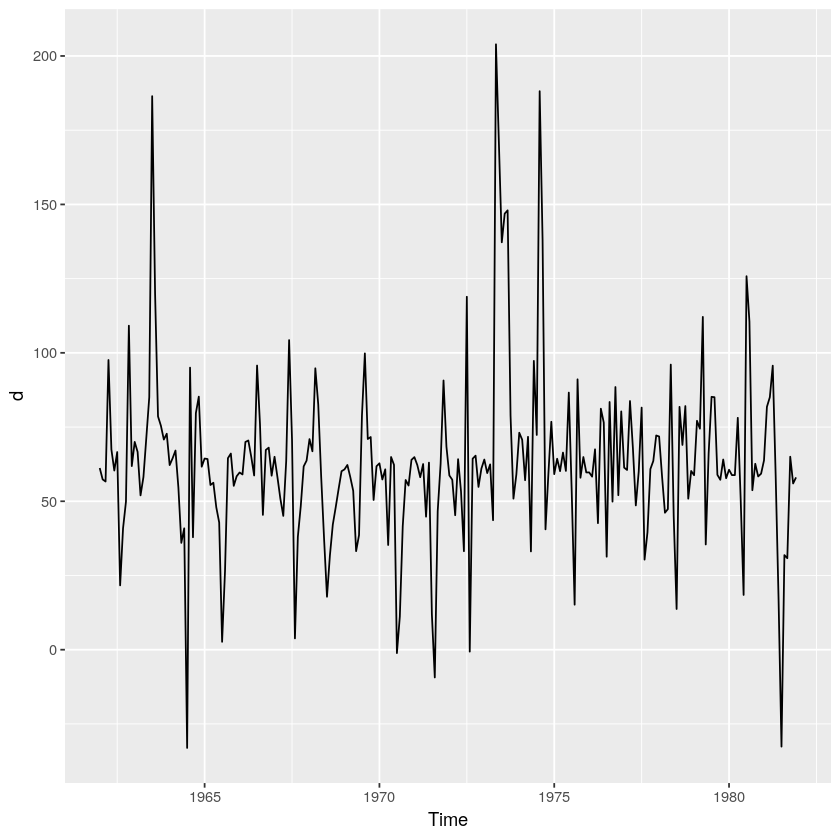

In [78]:
autoplot(d)

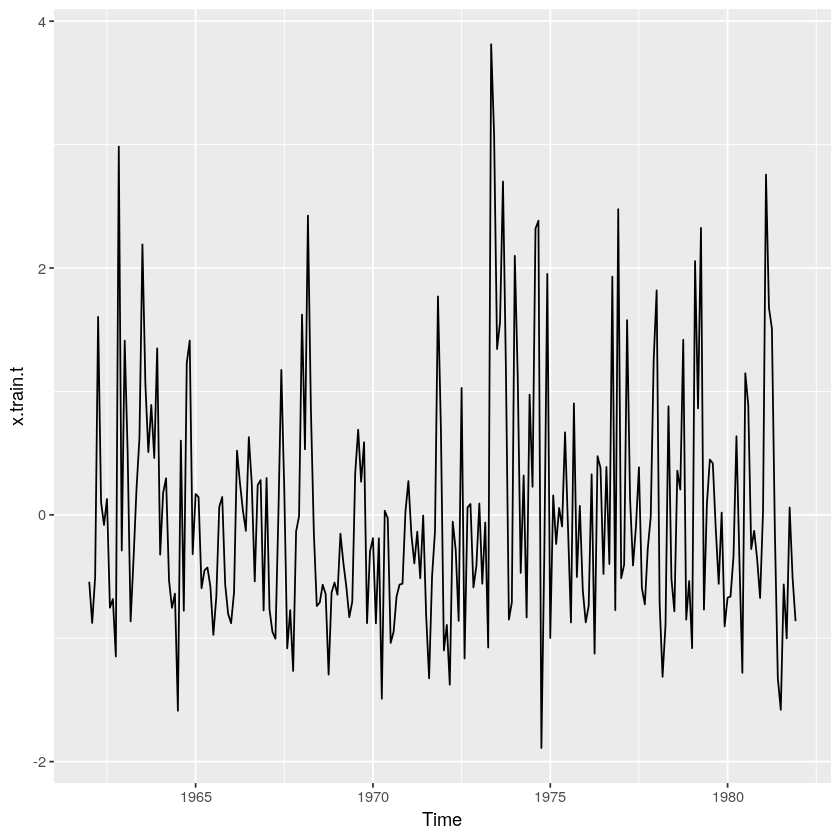

In [46]:
autoplot(x.train.t)

In [230]:
spiParameters<-function(x, n_months){
    x.n = rollapply(x, n_months, sum)
    fit.gamma <- fitdist(x, distr = "gamma", method = "mle")
    #probabilities = pgamma(x.n, shape = fit.gamma$estimate[1], rate = fit.gamma$estimate[2])
    #result = qnorm(probabilities, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)
    return(fit.gamma)
}

spiGenerator<-function(x, n_months){
    x.n = rollapply(x, n_months, sum)
    fit.gamma <- fitdist(x, distr = "gamma", method = "mle")
    probabilities = pgamma(x.n, shape = fit.gamma$estimate[1], rate = fit.gamma$estimate[2])
    result = qnorm(probabilities, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)
    return(result)
}

spiGeneratorParam<-function(x, params){
    probabilities = pgamma(x, shape = params$estimate[1], rate = params$estimate[2])
    result = qnorm(probabilities, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)
    return(result)
}

In [ ]:
x.train.spi = spiGenerator(as.numeric(x.train),3)

x.train.spi <- ts(x.train.spi, start = c(origin, 3), freq=f)r

In [226]:
x.train.param = spiParameters(as.numeric(x.train),3)

In [235]:
x.n = rollapply(as.numeric(A), 3, sum)

In [248]:
A.spi = spiGeneratorParam(x.n,x.train.param)

In [251]:
A.spi <- ts(A.spi, start = c(origin + n, 3), freq=f)

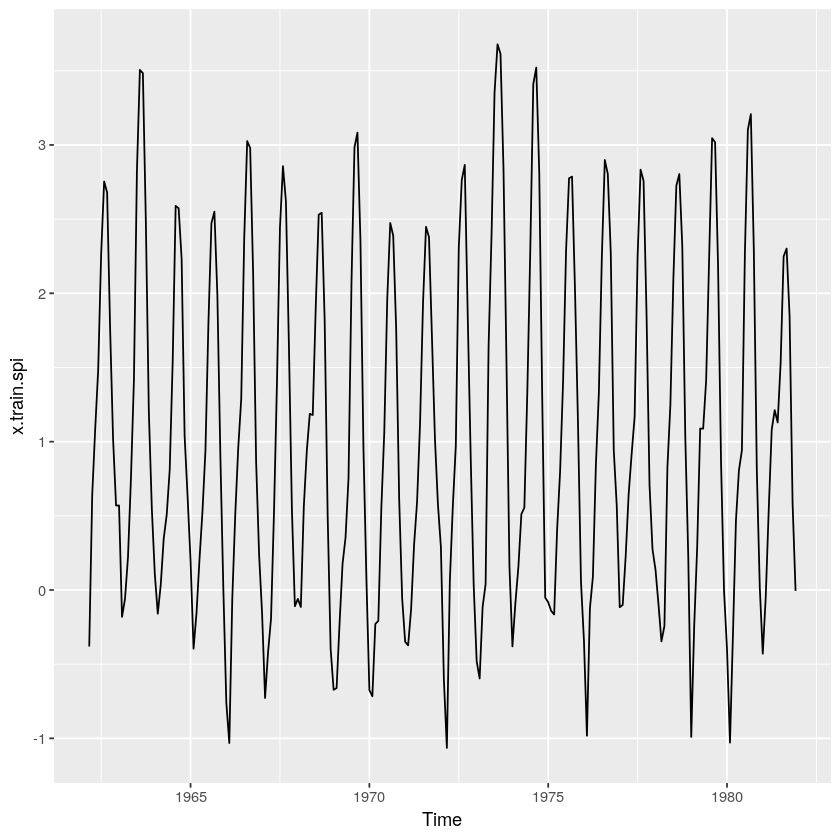

In [254]:
autoplot(x.train.spi)

# BoxCox Transformation then Z-transformation

In [18]:
auto.arima(x.train, trace = TRUE)


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2)(1,1,1)[12] with drift         : 2152.325
 ARIMA(0,0,0)(0,1,0)[12] with drift         : 2319.988
 ARIMA(1,0,0)(1,1,0)[12] with drift         : 2203.42
 ARIMA(0,0,1)(0,1,1)[12] with drift         : 2166.823
 ARIMA(0,0,0)(0,1,0)[12]                    : 2317.974
 ARIMA(2,0,2)(0,1,1)[12] with drift         : Inf
 ARIMA(2,0,2)(2,1,1)[12] with drift         : 2149.987
 ARIMA(2,0,2)(2,1,0)[12] with drift         : 2197.473
 ARIMA(2,0,2)(2,1,2)[12] with drift         : 2150.636
 ARIMA(2,0,2)(1,1,0)[12] with drift         : 2204.36
 ARIMA(1,0,2)(2,1,1)[12] with drift         : 2151.479
 ARIMA(3,0,2)(2,1,1)[12] with drift         : Inf
 ARIMA(2,0,1)(2,1,1)[12] with drift         : 2147.919
 ARIMA(1,0,0)(2,1,1)[12] with drift         : 2149.078
 ARIMA(2,0,1)(2,1,1)[12]                    : 2147.312
 ARIMA(2,0,1)(1,1,1)[12]                    : 2151.105
 ARIMA(2,0,1)(2,1,0)[12]                    : 2193.29
 ARIMA(2,0,1)(2,1

Series: x.train 
ARIMA(2,0,1)(2,1,0)[12] 

Coefficients:
         ar1      ar2      ma1     sar1     sar2
      0.9832  -0.2940  -0.6887  -0.7842  -0.2655
s.e.  0.2002   0.0709   0.2013   0.0644   0.0645

sigma^2 estimated as 1208:  log likelihood=-1133.88
AIC=2279.75   AICc=2280.13   BIC=2300.33

In [20]:
fit = auto.arima(x.train)


	Ljung-Box test

data:  Residuals from ARIMA(2,0,1)(2,1,0)[12]
Q* = 23.853, df = 19, p-value = 0.2018

Model df: 5.   Total lags used: 24



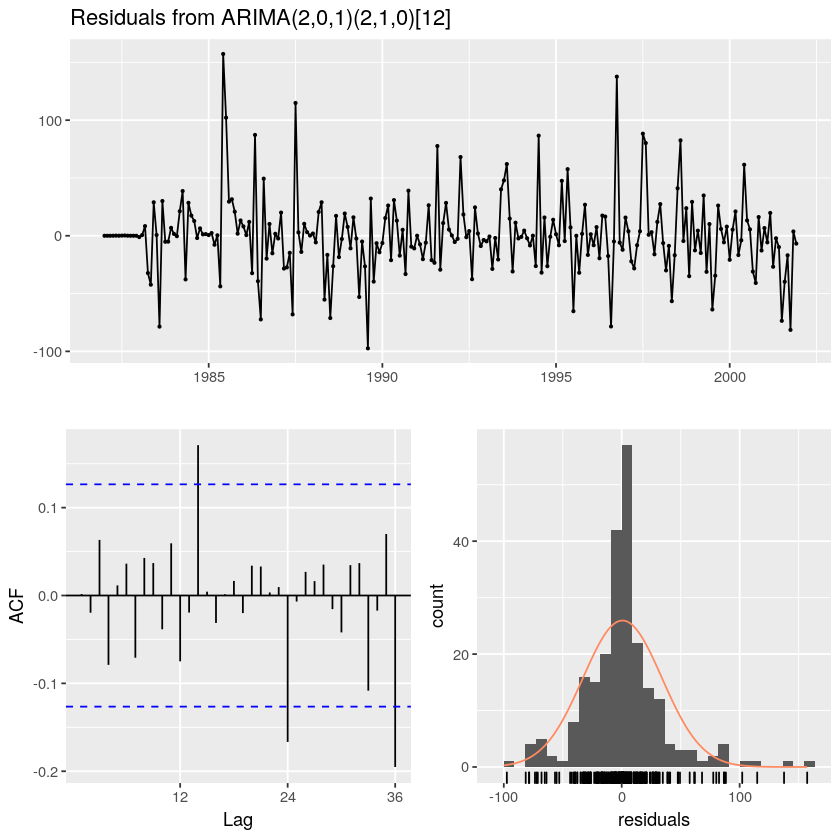

In [31]:
checkresiduals(fit)

In [128]:
fit = auto.arima(x.train)

Warning message in value[[3L]](cond):
“The chosen test encountered an error, so no seasonal differencing is selected. Check the time series data.”

In [129]:
A = forecast(auto.arima(x.train),h = 3)$mean

Warning message in value[[3L]](cond):
“The chosen test encountered an error, so no seasonal differencing is selected. Check the time series data.”

In [138]:
accuracy(A, x.test)

ME        RMSE     MAE      MPE      MAPE    ACF1 Theil's U
Test set -4.816393 5.082255 4.816393 -5434.64 5434.64 NA   13.99208

In [42]:
summary(A)


Forecast method: ARIMA(2,0,1)(2,1,0)[12]

Model Information:
Series: x.train 
ARIMA(2,0,1)(2,1,0)[12] 

Coefficients:
         ar1      ar2      ma1     sar1     sar2
      0.9832  -0.2940  -0.6887  -0.7842  -0.2655
s.e.  0.2002   0.0709   0.2013   0.0644   0.0645

sigma^2 estimated as 1208:  log likelihood=-1133.88
AIC=2279.75   AICc=2280.13   BIC=2300.33

Error measures:
                    ME     RMSE      MAE      MPE     MAPE      MASE       ACF1
Training set 0.6270245 33.50222 21.87614 -174.136 239.3422 0.7291341 0.00160466

Forecasts:
         Point Forecast      Lo 80     Hi 80      Lo 95     Hi 95
Jan 2002      15.883103 -28.658197  60.42440 -52.236937  84.00314
Feb 2002      11.164860 -35.267363  57.59708 -59.847097  82.17682
Mar 2002      29.214999 -17.217649  75.64765 -41.797608 100.22761
Apr 2002      23.275168 -23.333865  69.88420 -48.007197  94.55753
May 2002      43.033418  -3.740558  89.80739 -28.501205 114.56804
Jun 2002     109.883669  63.033674 156.73366  38.232784

In [215]:
A = inv_phase_average(A, 12, pa$averages, pa$stds)

In [183]:
#A = A*s + m
A = invBoxCox(A,lambda)

In [229]:
accuracy(A, x.test)

ME        RMSE     MAE      MPE       MAPE     ACF1      Theil's U
Test set -4.755197 80.77927 66.08345 -655.0749 686.6184 0.6346778 4.358489

In [216]:
accuracy(A, x.test)

ME        RMSE    MAE      MPE       MAPE    ACF1       Theil's U
Test set -3.439598 23.8229 16.71894 -86.63873 102.908 -0.2055476 0.5042349

In [201]:
accuracy(A, x.test)[2]/mean(x.test)

[1] 0.4630448

In [221]:
data <- data.frame(
  date = seq(as.Date("2003/1/1"), by = "month", length.out = 36),
  x.test,
  A
)

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


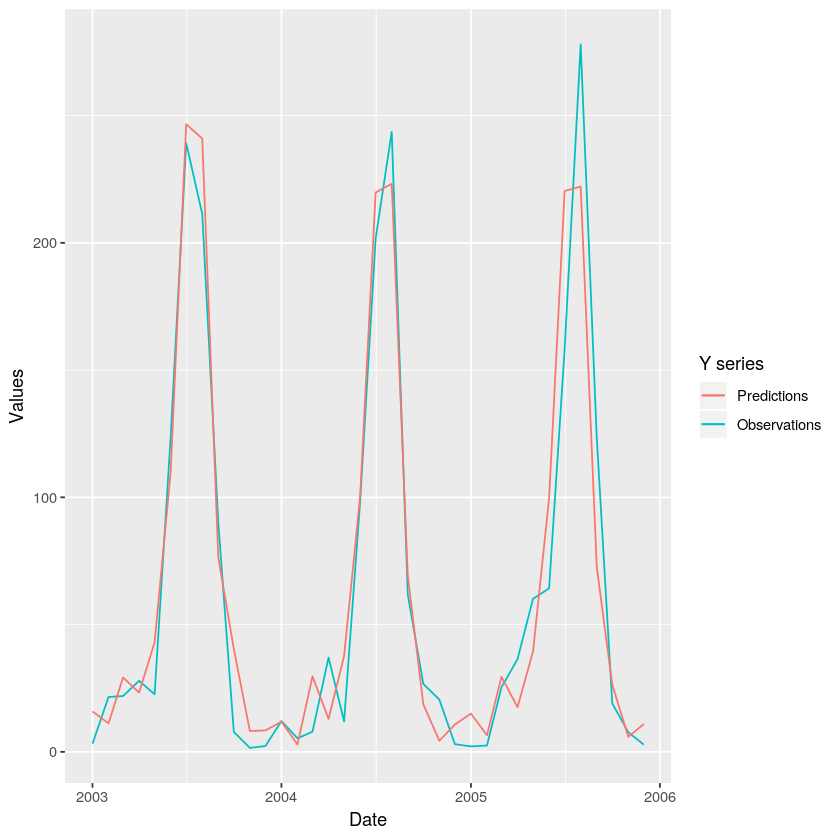

In [222]:
ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test,colour="red") ) +  # first layer
  geom_line(aes(y=A,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

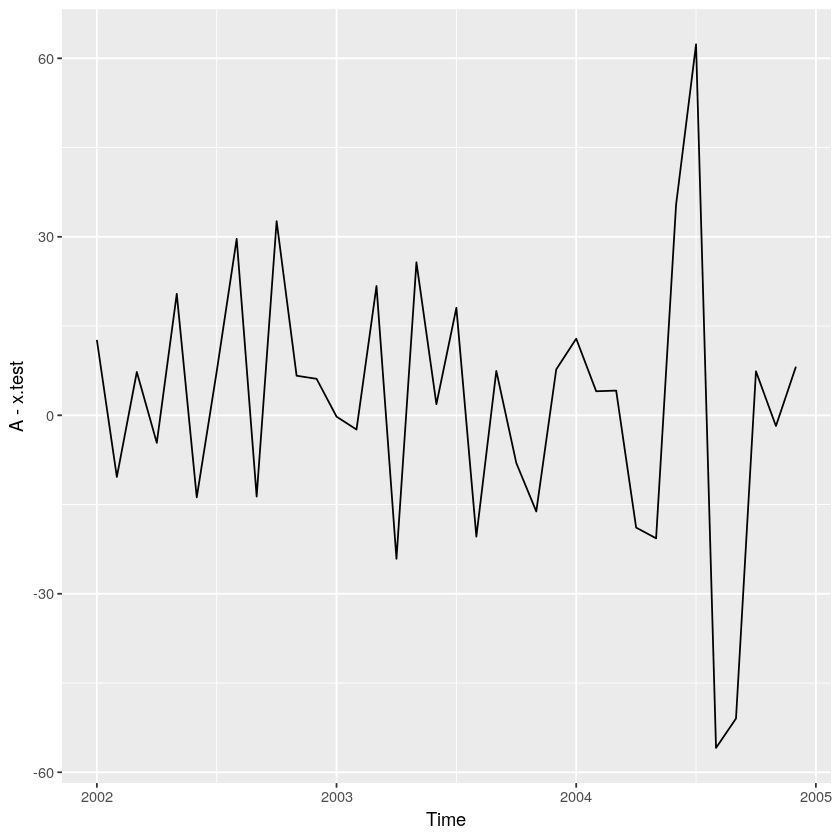

In [223]:
autoplot(A - x.test)

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


$x
[1] ""

attr(,"class")
[1] "labels"

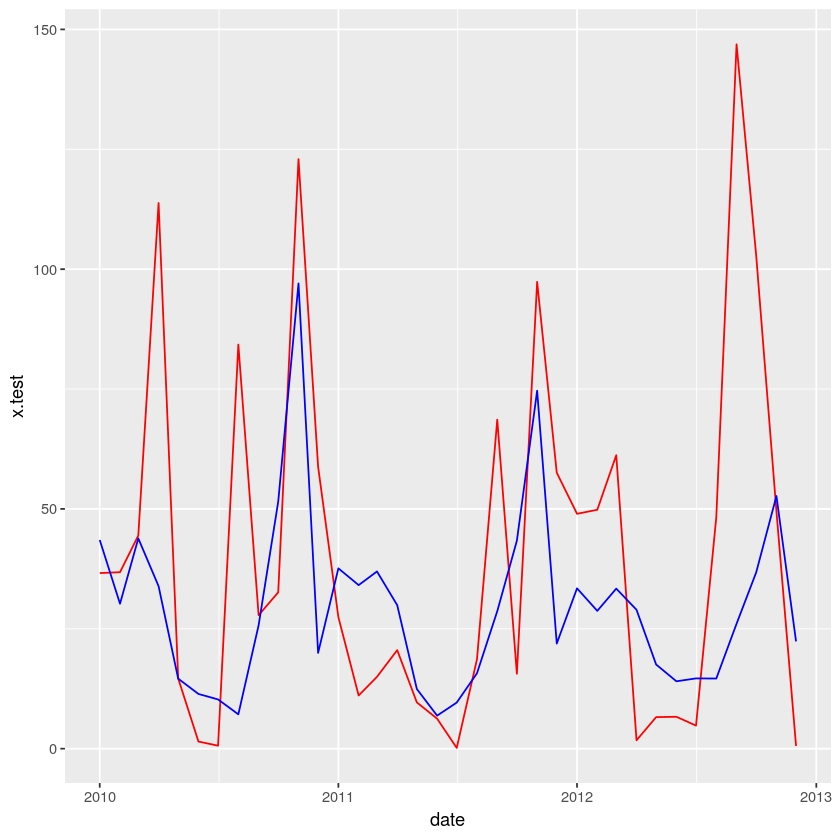

In [21]:
ggplot(data, aes(x=date)) +
  geom_line(aes(y=x.test), colour="red") + 
  geom_line(aes(y=A), colour="blue")
  xlab("")

In [36]:
x1 <- seq(length(x.test))
date <- seq(as.Date("2010/1/1"), by = "month", length.out = 12)
df <- data.frame(date,x.test,A)

require(ggplot2)

ggplot(df, aes(date)) +                    # basic graphical object
  geom_line(aes(y=x.test), colour="red") +  # first layer
  geom_line(aes(y=A), colour="blue") 

ERROR: Error in data.frame(date = seq(as.Date("2010/1/1"), by = "month", length.out = 12), : arguments imply differing number of rows: 12, 365


In [61]:
A = ets(x.train.t)

In [72]:
A = forecast(ets(x.train),h)

In [67]:
freq <- frequency(residuals(A))

In [68]:
lag <- ifelse(freq > 1, 2 * freq, 10)
lag <- min(lag, round(length(residuals)/5))
lag <- max(df+3, lag)

In [69]:
t = Box.test(residuals(A),fitdf = df,lag = lag,type="Ljung")

In [70]:
t$p.value

[1] 0.04126296

In [52]:
df = length(A$coef)

In [66]:
df = length(A$par)


	Ljung-Box test

data:  Residuals from ETS(M,A,M)
Q* = 26.475, df = 8, p-value = 0.0008707

Model df: 16.   Total lags used: 24



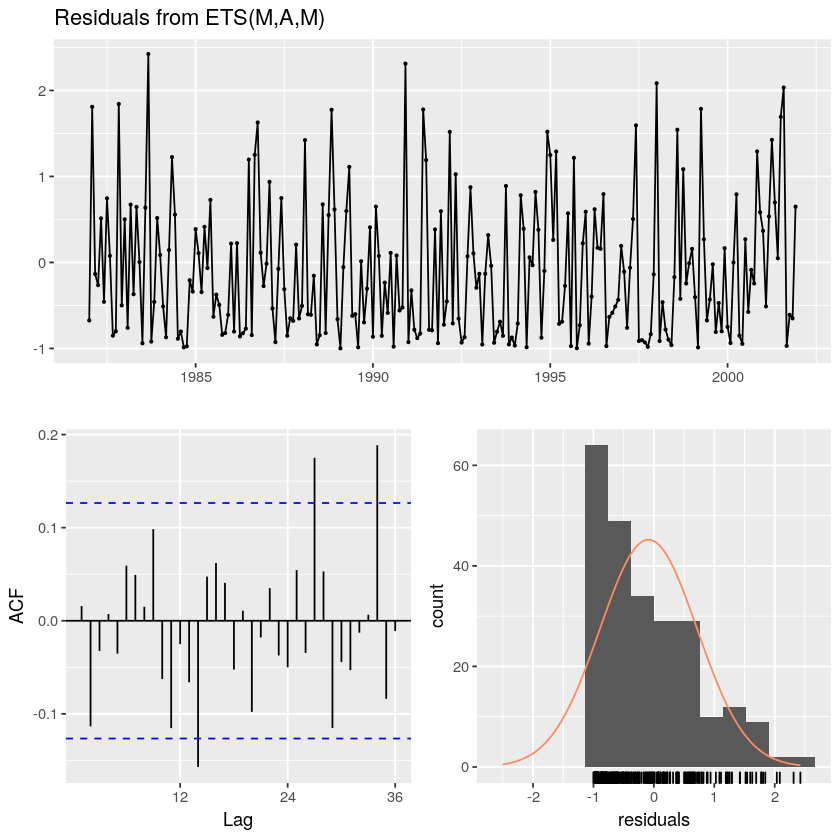

In [73]:
p = checkresiduals(A)

In [155]:
A = inv_phase_average(A, 12, pa$averages, pa$stds)

In [ ]:
A = A*s + m

In [115]:
A = invBoxCox(A,lambda)

In [156]:
accuracy(A, x.test)

ME        RMSE     MAE      MPE       MAPE     ACF1      Theil's U
Test set -5.570253 29.07438 17.87137 -2461.014 2480.268 0.2005367 3.171994

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


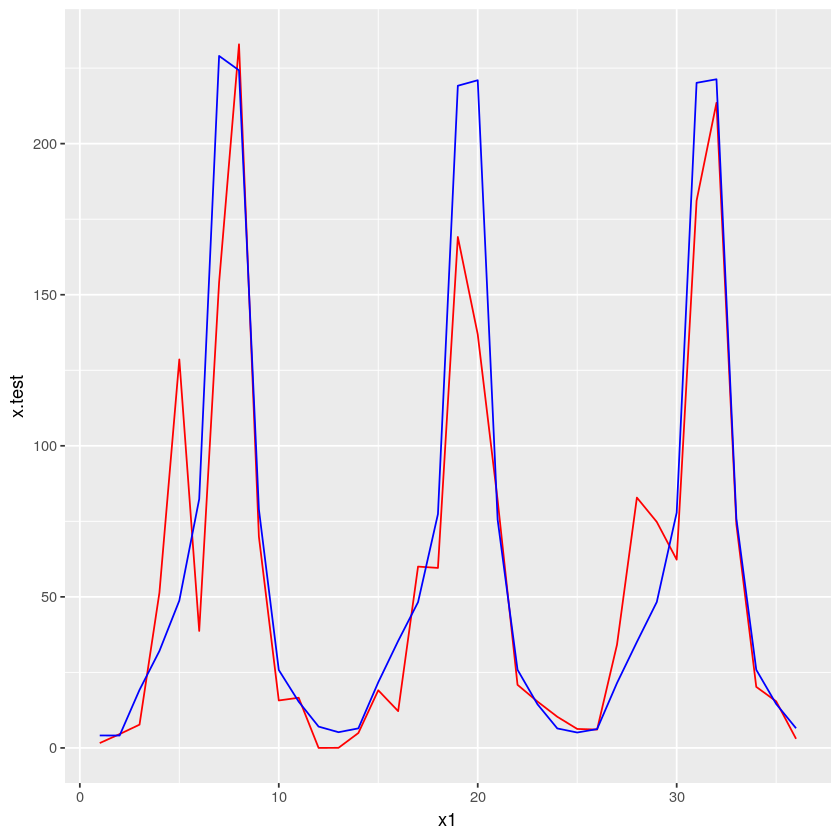

In [157]:
x1 <- seq(length(x.test))

df <- data.frame(x1,x.test,A)

require(ggplot2)

ggplot(df, aes(x1)) +                    # basic graphical object
  geom_line(aes(y=x.test), colour="red") +  # first layer
  geom_line(aes(y=A), colour="blue") 

In [22]:
A = forecast(auto.arima(x.train),h)$mean

In [137]:
A = inv_phase_average(A, 12, pa$averages, pa$stds)

In [37]:
A = A*s + m
A = invBoxCox(A,lambda)

In [23]:
accuracy(A, x.test)

ME        RMSE     MAE      MPE       MAPE    ACF1      Theil's U
Test set -8.052329 36.52253 30.47796 -1460.575 1482.99 0.2738818 1.083161

In [24]:
accuracy(A, x.test)[2]/mean(x.test)

[1] 0.9063661

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


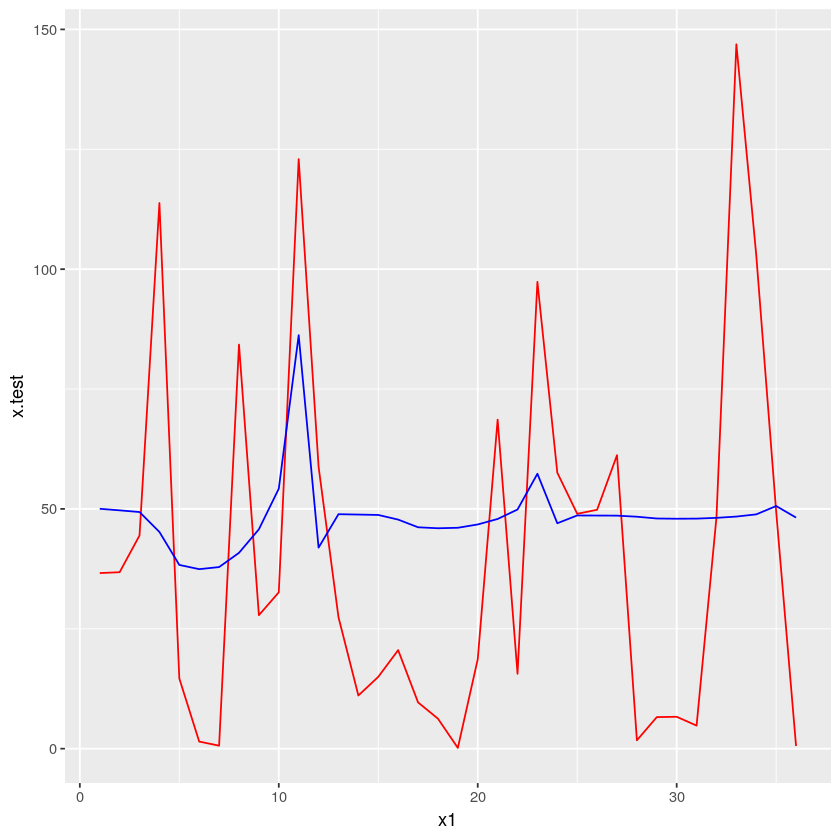

In [25]:
x1 <- seq(length(x.test))

df <- data.frame(x1,x.test,A)

require(ggplot2)

ggplot(df, aes(x1)) +                    # basic graphical object
  geom_line(aes(y=x.test), colour="red") +  # first layer
  geom_line(aes(y=A), colour="blue") 

In [118]:
A = forecast(ets(x.train.t),h)$mean

In [119]:
A = inv_phase_average(A, 12, pa$averages, pa$stds)

In [ ]:
A = A*s + m

In [120]:
A = invBoxCox(A,lambda)

In [121]:
accuracy(A, x.test)

ME       RMSE     MAE      MPE       MAPE     ACF1     Theil's U
Test set 5.708892 32.55934 22.75545 -399.6394 440.3124 0.100423 0.7589851

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


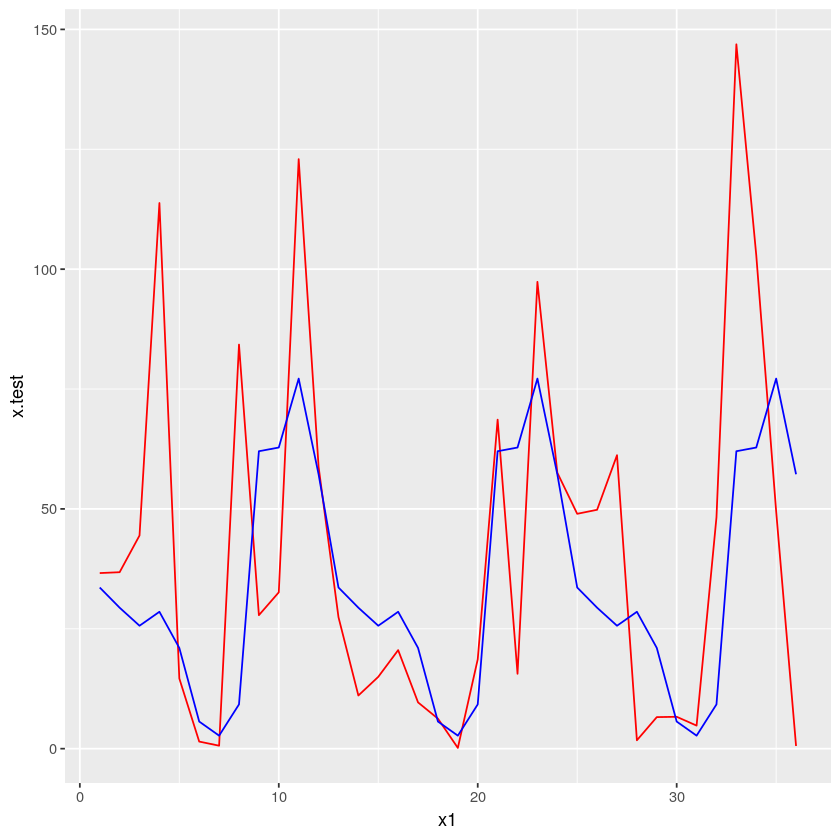

In [122]:
x1 <- seq(length(x.test))

df <- data.frame(x1,x.test,A)

require(ggplot2)

ggplot(df, aes(x1)) +                    # basic graphical object
  geom_line(aes(y=x.test), colour="red") +  # first layer
  geom_line(aes(y=A), colour="blue") 

# BoxCox Transformation

In [23]:
A = forecast(auto.arima(x.train, lambda=lambda, biasadj=TRUE),h, lambda= lambda,biasadj=TRUE)$mean

In [24]:
accuracy(A, x.test)

ME        RMSE     MAE     MPE       MAPE     ACF1      Theil's U
Test set -13.77174 42.19057 25.8663 -1748.208 1776.628 0.4049428 1.811771

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


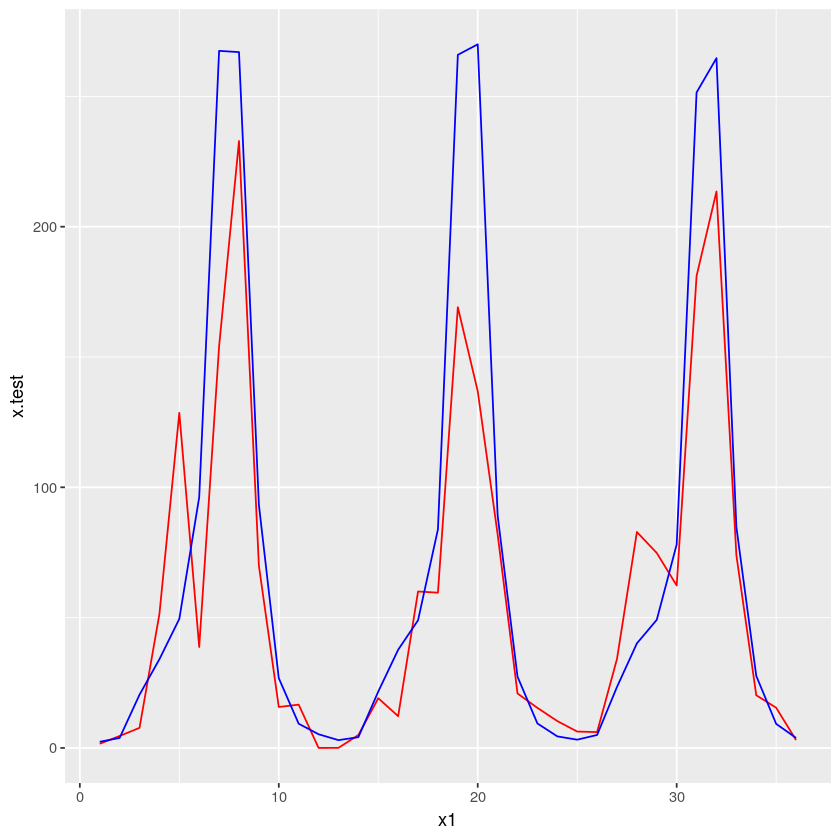

In [25]:
require(ggplot2)

x1 <- seq(length(x.test))

df <- data.frame(x1,x.test,A)

ggplot(df, aes(x1)) +                    # basic graphical object
  geom_line(aes(y=x.test), colour="red") +  # first layer
  geom_line(aes(y=A), colour="blue") 

In [33]:
E = forecast(ets(x.train, lambda = lambda), h, lambda = lambda, biasadj=TRUE)$mean

In [34]:
accuracy(E, x.test)

ME        RMSE     MAE      MPE       MAPE     ACF1      Theil's U
Test set -16.07375 38.96846 29.54458 -725.9645 742.2819 0.2096272 0.6458285

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


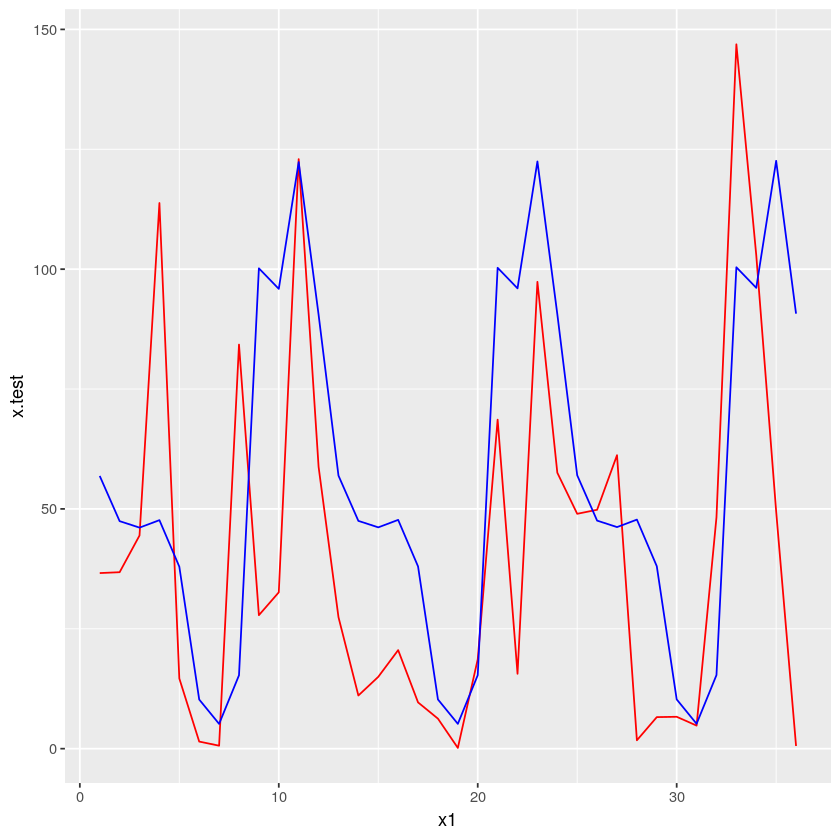

In [35]:
require(ggplot2)

x1 <- seq(length(x.test))

df <- data.frame(x1,x.test,E)

ggplot(df, aes(x1)) +                    # basic graphical object
  geom_line(aes(y=x.test), colour="red") +  # first layer
  geom_line(aes(y=E), colour="blue") 

In [54]:
d1<-c(2,3,2,3,2,3)

In [55]:
forecast(Arima(d1,order=c(0,0,0)))$mean

Time Series:
Start = 7 
End = 16 
Frequency = 1 
 [1] 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5

In [62]:
forecast(Arima(d1,order=c(0,0,0), lambda=0), lambda = 0, biasadj = TRUE)$mean

Time Series:
Start = 7 
End = 16 
Frequency = 1 
 [1] 2.509895 2.509895 2.509895 2.509895 2.509895 2.509895 2.509895 2.509895
 [9] 2.509895 2.509895

In [53]:
#x.fit <- stl(BoxCox(x.train,lambda), s.window="periodic", robust = TRUE)
E = forecast(stl(x.train,s.window="periodic",robust = TRUE), h=m*f, biasadj=FALSE)$mean

ERROR: Error in stl(x.train, s.window = "periodic", biasadj = FALSE, robust = TRUE): unused argument (biasadj = FALSE)


In [48]:
accuracy(E, x.test)

ME       RMSE     MAE      MPE      MAPE     ACF1      Theil's U
Test set 4.665683 35.34676 23.88554 1658.307 1677.333 0.2649728 3.800144

In [49]:
mean(x.test)

[1] 57.94278

In [50]:
accuracy(A, x.test)[2]/mean(x.test)

[1] 0.728142

In [89]:
x.fit <- stl(BoxCox(x.train,lambda), s.window="periodic", robust = TRUE)
#E = forecast(stl((x.fit,s.window="periodic", robust = TRUE), h=m*f,lambda= lambda, biasadj=FALSE)$mean
E = forecast(x.fit, h=m*f, lambda=lambda, biasadj=FALSE)$mean

In [90]:
accuracy(E, x.test)

ME       RMSE     MAE      MPE       MAPE     ACF1      Theil's U
Test set 5.318714 32.52179 22.77266 -382.5073 422.7635 0.1004697 0.7614206

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


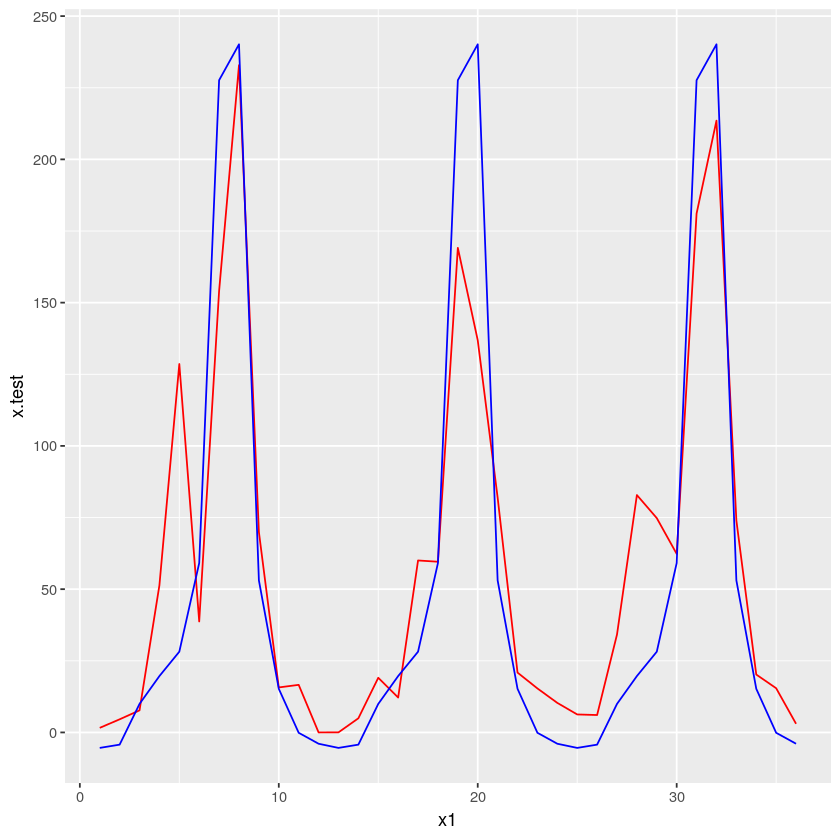

In [51]:
require(ggplot2)

x1 <- seq(length(x.test))

df <- data.frame(x1,x.test,E)

ggplot(df, aes(x1)) +                    # basic graphical object
  geom_line(aes(y=x.test), colour="red") +  # first layer
  geom_line(aes(y=E), colour="blue") 

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


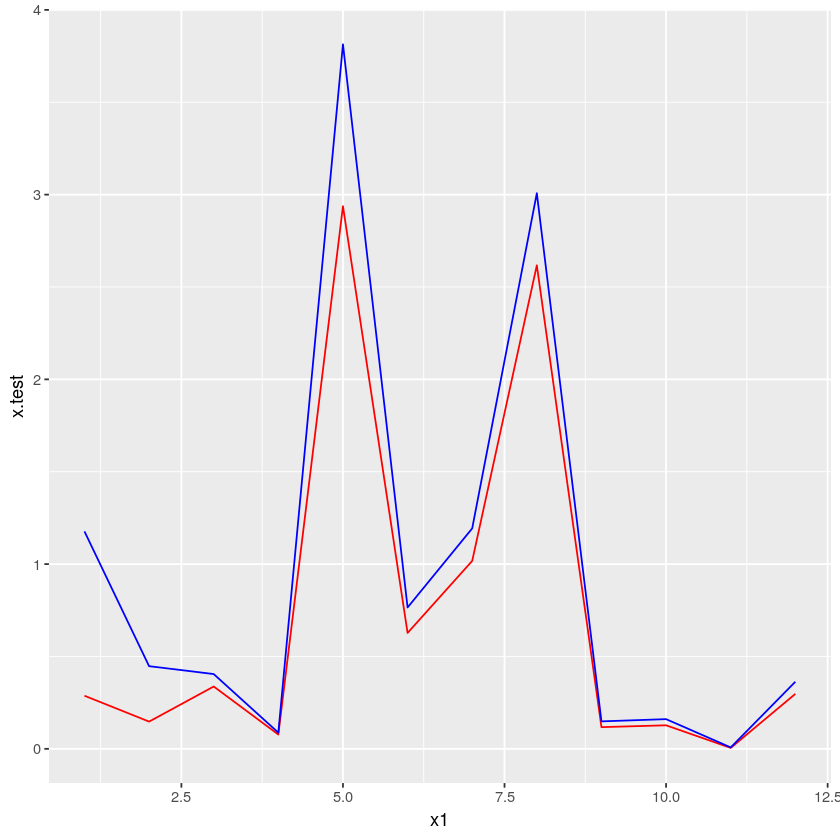

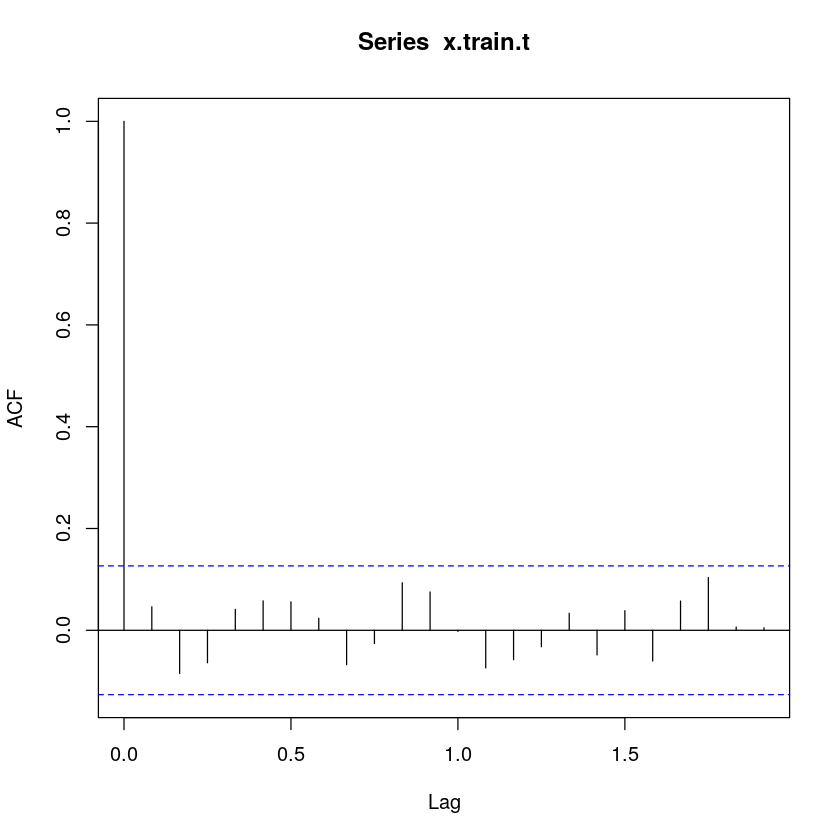

In [126]:
acf(x.train.t)

In [6]:
auto.arima(x, trace=TRUE)


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 1776.071
 ARIMA(0,0,0) with non-zero mean : 2297.984
 ARIMA(1,0,0) with non-zero mean : 1849.886
 ARIMA(0,0,1) with non-zero mean : 1965.486
 ARIMA(0,0,0) with zero mean     : 2296.006
 ARIMA(1,0,2) with non-zero mean : 1773.668
 ARIMA(1,0,1) with non-zero mean : 1836.072
 ARIMA(1,0,3) with non-zero mean : 1774.848
 ARIMA(2,0,3) with non-zero mean : 1777.112
 ARIMA(1,0,2) with zero mean     : 1771.656
 ARIMA(0,0,2) with zero mean     : 1773.953
 ARIMA(2,0,2) with zero mean     : 1774.111
 ARIMA(1,0,1) with zero mean     : 1834.065
 ARIMA(1,0,3) with zero mean     : 1772.816
 ARIMA(0,0,1) with zero mean     : 1963.5
 ARIMA(2,0,3) with zero mean     : 1775.265

 Now re-fitting the best model(s) without approximations...

 ARIMA(1,0,2) with zero mean     : 1770.445

 Best model: ARIMA(1,0,2) with zero mean     



Series: x 
ARIMA(1,0,2) with zero mean 

Coefficients:
         ar1     ma1     ma2
      0.1484  0.6215  0.4602
s.e.  0.0646  0.0571  0.0414

sigma^2 estimated as 0.5076:  log likelihood=-881.2
AIC=1770.4   AICc=1770.44   BIC=1789.22

In [253]:
library(ncdf4)

In [254]:
nc <- nc_open("spi3_6_12_1deg_cru_ts_3_21_1949_2012.nc")

lat <- ncvar_get(nc,"lat",verbose=F)
lon <- ncvar_get(nc,"lon",verbose=F)

In [9]:
time <- ncvar_get(nc,"time",verbose=F)

In [255]:
attributes(nc$var)$nameas

NULL

In [256]:
spi3 <- ncvar_get(nc, attributes(nc$var)$names[1])

In [257]:
lat[104]

[1] 13.5

In [259]:
lon[219]

[1] 38.5

In [260]:
data<-spi3[219,104,]

In [284]:
x<-data

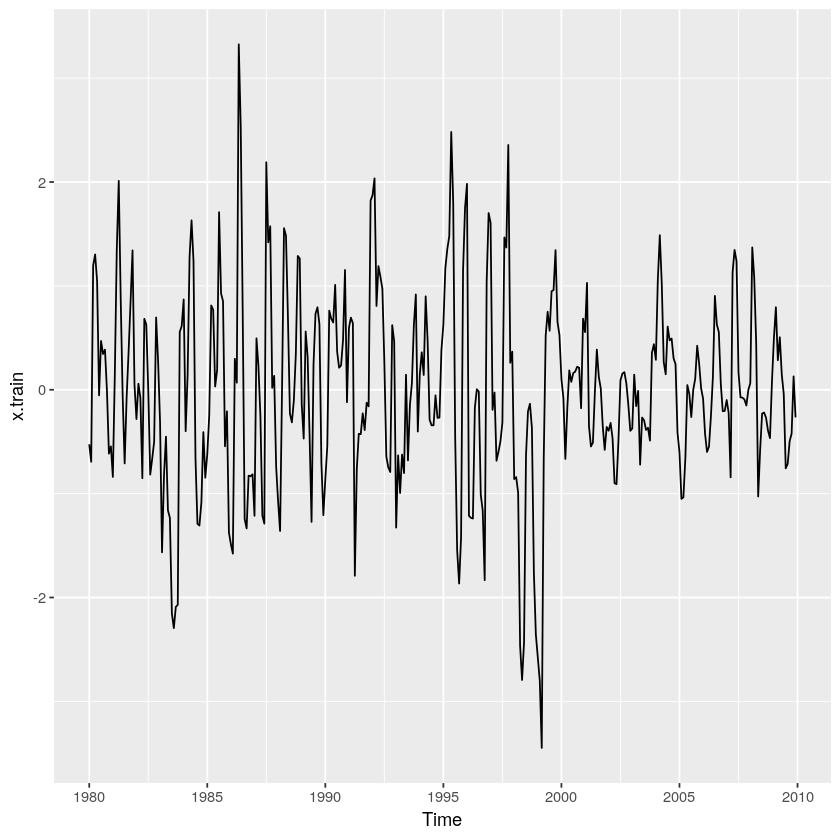

In [288]:
n=30
# Set forecasting window length (in years)
m=1
# Set start year
origin = 1980
# Se1 annual sampling rate
f = 12
h = m*f

x.ts = ts(x[385:length(x)], start=c(origin, 1), freq=f)
x.train <- window(x.ts, origin,origin+n - 1/f)
x.test <- window(x.ts, origin+n, origin+n+m - 1/f)

autoplot(x.train)

In [292]:
lambda <- BoxCox.lambda(x.train)

x.train.t <- BoxCox(x.train, lambda)

In [291]:
pa = phase_average(x.train.t, 12)
x.train.t <- ts(pa$result, start = c(origin, 1), freq=f)

In [299]:
A = forecast(auto.arima(x.train, lambda=lambda, biasadj=TRUE),h, lambda= lambda,biasadj=TRUE)$mean

In [300]:
A

             Jan         Feb         Mar         Apr         May         Jun
2010         NaN         NaN   1.0960034   0.7772551   0.6671165   0.7485020
             Jul         Aug         Sep         Oct         Nov         Dec
2010   0.8763042   1.0776578   1.3915624   1.9509217   3.3224423 173.7176684

In [301]:
x.test

              Jan          Feb          Mar          Apr          May
2010  0.050470829 -0.003528953 -0.614075065 -1.182719588 -0.539522171
              Jun          Jul          Aug          Sep          Oct
2010 -0.548743963 -0.512543082 -0.621076465 -0.497010469 -0.456294298
              Nov          Dec
2010  0.178296924  0.052729368

In [303]:
accuracy(A, x.test)

ME        RMSE     MAE      MPE       MAPE     ACF1         Theil's U
Test set -19.03664 54.94859 19.03664 -32875.86 33347.12 -0.002822225 6.287888

In [306]:
E = forecast(ets(x.train), h,biasadj=TRUE)$mean

In [308]:
E

            Jan        Feb        Mar        Apr        May        Jun
2010 -0.2657776 -0.2657776 -0.2657776 -0.2657776 -0.2657776 -0.2657776
            Jul        Aug        Sep        Oct        Nov        Dec
2010 -0.2657776 -0.2657776 -0.2657776 -0.2657776 -0.2657776 -0.2657776

In [307]:
accuracy(E, x.test)

ME         RMSE      MAE       MPE       MAPE     ACF1      Theil's U
Test set -0.1253905 0.3938519 0.3489036 -460.1218 778.4358 0.4160752 0.5714368

In [44]:
x.fit = auto.arima(x.train, trace=FALSE)

In [45]:
x.fit

Series: x.train 
ARIMA(2,0,2) with zero mean 

Coefficients:
         ar1      ar2     ma1     ma2
      0.0556  -0.0210  0.7514  0.5420
s.e.  0.1204   0.0949  0.1082  0.0599

sigma^2 estimated as 0.4552:  log likelihood=-367.65
AIC=745.3   AICc=745.47   BIC=764.73

In [46]:
x.pred = forecast(x.fit,h)

In [32]:
x.pred forecast(x.fit,h)

ERROR: Error in parse(text = x, srcfile = src): <text>:1:8: unexpected symbol
1: x.pred forecast
           ^


In [287]:
x.test

              Jan          Feb          Mar          Apr          May
2010  0.050470829 -0.003528953 -0.614075065 -1.182719588 -0.539522171
2011  0.006233692 -0.308405161 -0.538550735 -0.958381474 -1.172433376
              Jun          Jul          Aug          Sep          Oct
2010 -0.548743963 -0.512543082 -0.621076465 -0.497010469 -0.456294298
2011 -0.770851672 -0.529146552 -0.263372779 -0.297406077 -0.279794097
              Nov          Dec
2010  0.178296924  0.052729368
2011 -0.406598806  0.169330359

In [75]:
x.pred

         Point Forecast      Lo 80     Hi 80     Lo 95    Hi 95
Jan 2010  -1.243100e-01 -0.9889252 0.7403052 -1.446625 1.198005
Feb 2010  -2.263260e-01 -1.3373587 0.8847068 -1.925504 1.472852
Mar 2010  -9.962193e-03 -1.2239404 1.2040161 -1.866582 1.846657
Apr 2010   4.205866e-03 -1.2098369 1.2182486 -1.852512 1.860924
May 2010   4.432049e-04 -1.2136374 1.2145238 -1.856333 1.857219
Jun 2010  -6.381799e-05 -1.2141447 1.2140171 -1.856840 1.856713
Jul 2010  -1.286641e-05 -1.2140938 1.2140680 -1.856789 1.856764
Aug 2010   6.270850e-07 -1.2140803 1.2140815 -1.856776 1.856777
Sep 2010   3.054148e-07 -1.2140806 1.2140812 -1.856776 1.856777
Oct 2010   3.784026e-09 -1.2140809 1.2140809 -1.856777 1.856777
Nov 2010  -6.212339e-09 -1.2140809 1.2140809 -1.856777 1.856777
Dec 2010  -4.247777e-10 -1.2140809 1.2140809 -1.856777 1.856777
Jan 2011   1.070363e-10 -1.2140809 1.2140809 -1.856777 1.856777
Feb 2011   1.488043e-11 -1.2140809 1.2140809 -1.856777 1.856777
Mar 2011  -1.424015e-12 -1.2140809 1.214

In [48]:
error = accuracy(x.pred$mean, x.test)

In [49]:
error

ME         RMSE      MAE       MPE       MAPE     ACF1      Theil's U
Test set -0.4036404 0.5615214 0.4706544 -157.0125 369.1044 0.5116894 0.9892453

In [36]:
ets(x)

ETS(A,N,N) 

Call:
 ets(y = x) 

  Smoothing parameters:
    alpha = 0.9587 

  Initial states:
    l = 0.0031 

  sigma:  0.8606

     AIC     AICc      BIC 
4875.867 4875.899 4889.798 

In [51]:
x1 <- seq(length(x.test))

In [52]:
df <- data.frame(x1,x.test,x.pred$mean)

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


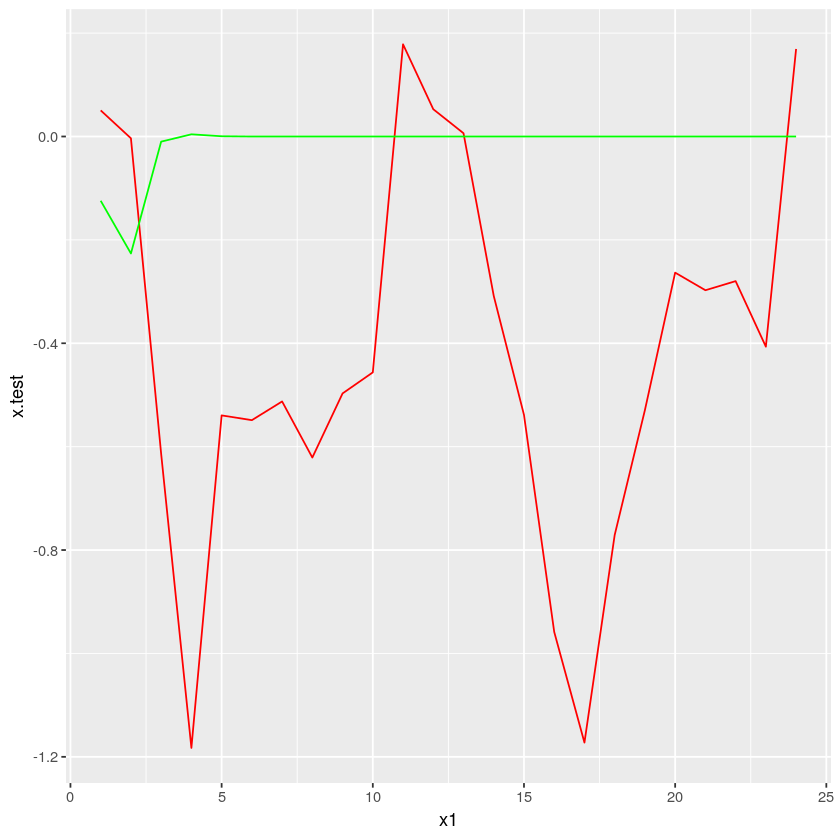

In [54]:
require(ggplot2)

ggplot(df, aes(x1)) +                    # basic graphical object
  geom_line(aes(y=x.test), colour="red") +  # first layer
  geom_line(aes(y=x.pred$mean), colour="green") 

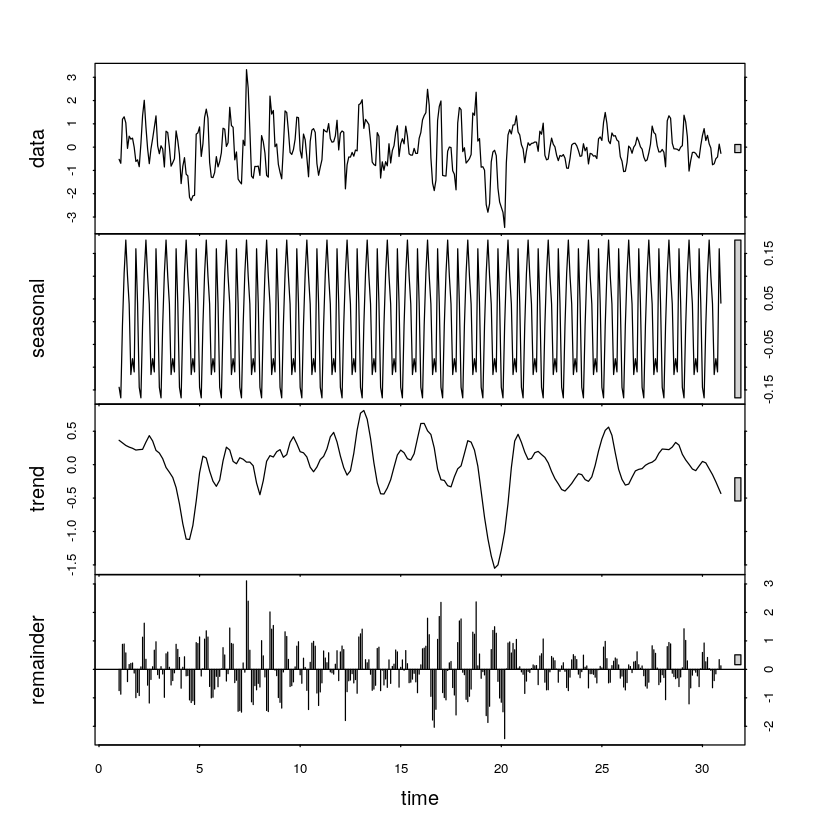

In [65]:
t = ts(x.train, frequency=12)
decomp = stl(t, s.window="periodic")
deseasonal_cnt <- seasadj(decomp)
plot(decomp)

In [68]:
adf.test(t, alternative = "stationary")

Warning message in adf.test(t, alternative = "stationary"):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  t
Dickey-Fuller = -6.7642, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


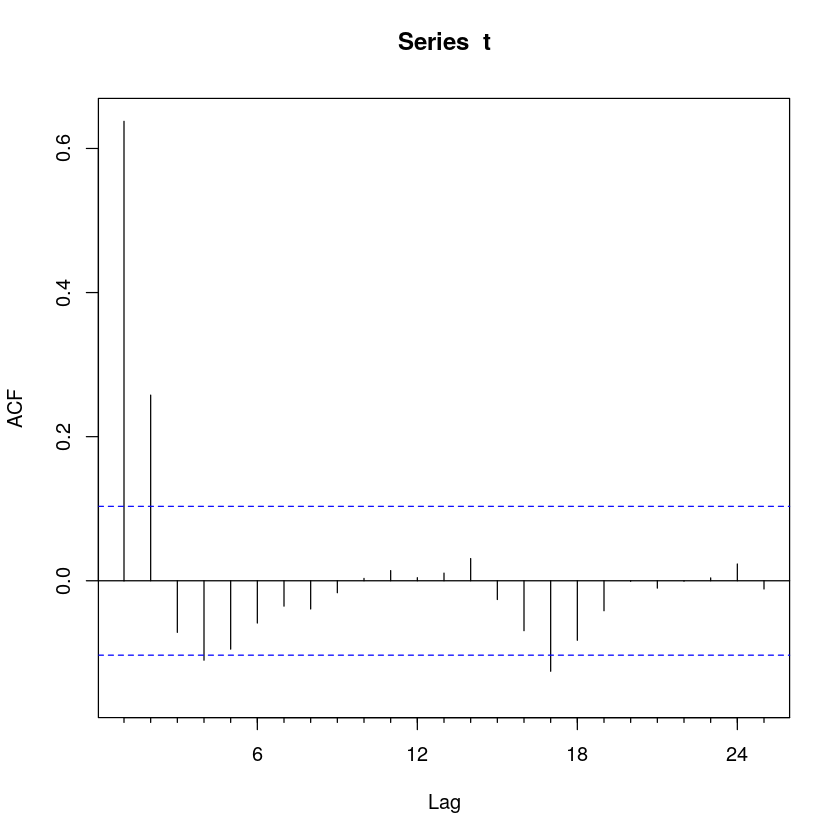

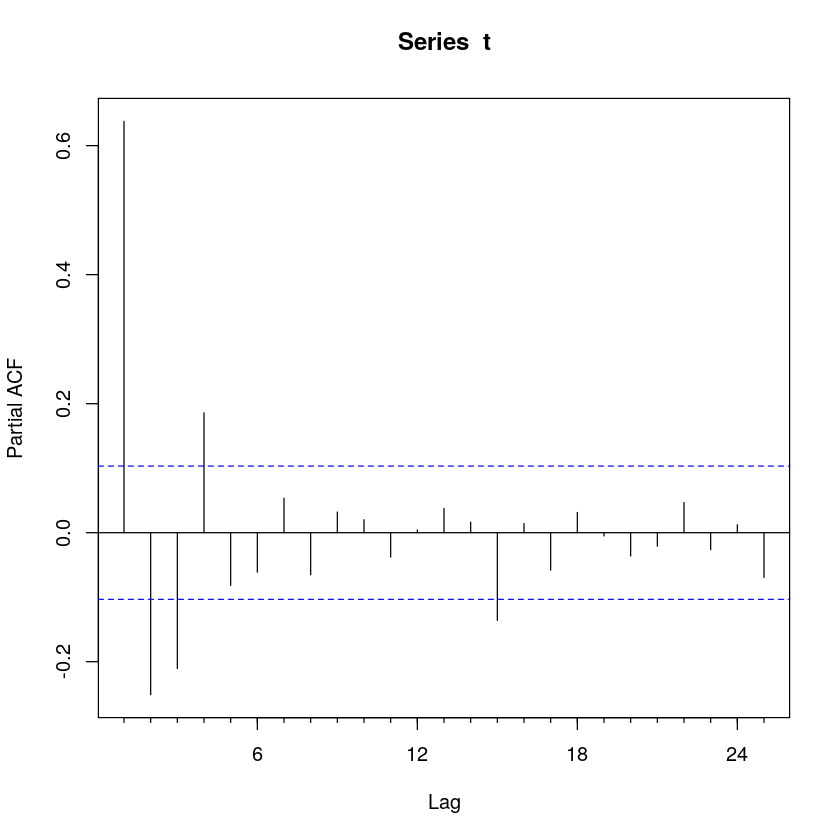

In [69]:
Acf(t)
Pacf(t)

In [ ]:
count_d1 = diff(deseasonal_cnt, differences = 1)
plot(count_d1)
adf.test(count_d1, alternative = "stationary")



In [71]:
x.fit = auto.arima(deseasonal_cnt, seasonal=FALSE)

In [90]:
x.pred = forecast(x.fit, )

[1] 36

In [72]:
decomp$

 Call:
 stl(x = t, s.window = "periodic")

Components
          seasonal        trend    remainder
Jan  1 -0.14421917  0.364724955 -0.745387267
Feb  1 -0.16740270  0.345473059 -0.871215035
Mar  1 -0.00713300  0.326221162  0.878846704
Apr  1  0.10648554  0.306900708  0.889271121
May  1  0.17944303  0.287580255  0.576684328
Jun  1  0.10082151  0.275231372 -0.429278520
Jul  1  0.03871984  0.262882490  0.168173582
Aug  1 -0.11613762  0.253887191  0.206813793
Sep  1 -0.08136219  0.244891893  0.222674305
Oct  1 -0.11035486  0.231760262 -0.127351326
Nov  1  0.16028247  0.218628632 -0.993420807
Dec  1  0.04085716  0.221860970 -0.807768755
Jan  2 -0.14421917  0.225093308 -0.919752651
Feb  2 -0.16740270  0.227108633  0.085462851
Mar  2 -0.00713300  0.229123958  1.129349335
Apr  2  0.10648554  0.283256290  1.621352506
May  2  0.17944303  0.337388621  0.353415657
Jun  2  0.10082151  0.385831986 -0.554720928
Jul  2  0.03871984  0.434275350 -1.181912572
Aug  2 -0.11613762  0.394450142 -0.354423958
S

In [76]:
library(ncdf4)
library('forecast')
library('tseries')
library("TTR")
library("FitAR")

Loading required package: lattice
Loading required package: leaps
Loading required package: ltsa
Loading required package: bestglm

Attaching package: ‘FitAR’

The following object is masked from ‘package:forecast’:

    BoxCox



In [80]:
nc <- nc_open("spi3_6_12_1deg_cru_ts_3_21_1949_2012.nc")

In [81]:
lat <- ncvar_get(nc,"lat",verbose=F)
lon <- ncvar_get(nc,"lon",verbose=F)

In [4]:
lat[101]

[1] 10.5

In [5]:
lat

[1] -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 -81.5 -80.5 -79.5 -78.5
 [13] -77.5 -76.5 -75.5 -74.5 -73.5 -72.5 -71.5 -70.5 -69.5 -68.5 -67.5 -66.5
 [25] -65.5 -64.5 -63.5 -62.5 -61.5 -60.5 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5
 [37] -53.5 -52.5 -51.5 -50.5 -49.5 -48.5 -47.5 -46.5 -45.5 -44.5 -43.5 -42.5
 [49] -41.5 -40.5 -39.5 -38.5 -37.5 -36.5 -35.5 -34.5 -33.5 -32.5 -31.5 -30.5
 [61] -29.5 -28.5 -27.5 -26.5 -25.5 -24.5 -23.5 -22.5 -21.5 -20.5 -19.5 -18.5
 [73] -17.5 -16.5 -15.5 -14.5 -13.5 -12.5 -11.5 -10.5  -9.5  -8.5  -7.5  -6.5
 [85]  -5.5  -4.5  -3.5  -2.5  -1.5  -0.5   0.5   1.5   2.5   3.5   4.5   5.5
 [97]   6.5   7.5   8.5   9.5  10.5  11.5  12.5  13.5  14.5  15.5  16.5  17.5
[109]  18.5  19.5  20.5  21.5  22.5  23.5  24.5  25.5  26.5  27.5  28.5  29.5
[121]  30.5  31.5  32.5  33.5  34.5  35.5  36.5  37.5  38.5  39.5  40.5  41.5
[133]  42.5  43.5  44.5  45.5  46.5  47.5  48.5  49.5  50.5  51.5  52.5  53.5
[145]  54.5  55.5  56.5  57.5  58.5  59.5  60.5  61.5  62.5  63.5  64.5  65.5
[157]  66.5  67.5  68.5  69.5  70.5  71.5  72.5  73.5  74.5  75.5  76.5  77.5
[169]  78.5  79.5  80.5  81.5  82.5  83.5  84.5  85.5  86.5  87.5  88.5  89.5

In [6]:
lon[216]

[1] 35.5

In [7]:
lon

[1] -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 -172.5 -171.5 -170.5
 [11] -169.5 -168.5 -167.5 -166.5 -165.5 -164.5 -163.5 -162.5 -161.5 -160.5
 [21] -159.5 -158.5 -157.5 -156.5 -155.5 -154.5 -153.5 -152.5 -151.5 -150.5
 [31] -149.5 -148.5 -147.5 -146.5 -145.5 -144.5 -143.5 -142.5 -141.5 -140.5
 [41] -139.5 -138.5 -137.5 -136.5 -135.5 -134.5 -133.5 -132.5 -131.5 -130.5
 [51] -129.5 -128.5 -127.5 -126.5 -125.5 -124.5 -123.5 -122.5 -121.5 -120.5
 [61] -119.5 -118.5 -117.5 -116.5 -115.5 -114.5 -113.5 -112.5 -111.5 -110.5
 [71] -109.5 -108.5 -107.5 -106.5 -105.5 -104.5 -103.5 -102.5 -101.5 -100.5
 [81]  -99.5  -98.5  -97.5  -96.5  -95.5  -94.5  -93.5  -92.5  -91.5  -90.5
 [91]  -89.5  -88.5  -87.5  -86.5  -85.5  -84.5  -83.5  -82.5  -81.5  -80.5
[101]  -79.5  -78.5  -77.5  -76.5  -75.5  -74.5  -73.5  -72.5  -71.5  -70.5
[111]  -69.5  -68.5  -67.5  -66.5  -65.5  -64.5  -63.5  -62.5  -61.5  -60.5
[121]  -59.5  -58.5  -57.5  -56.5  -55.5  -54.5  -53.5  -52.5  -51.5  -50.5
[131]  -49.5  -48.5  -47.5  -46.5  -45.5  -44.5  -43.5  -42.5  -41.5  -40.5
[141]  -39.5  -38.5  -37.5  -36.5  -35.5  -34.5  -33.5  -32.5  -31.5  -30.5
[151]  -29.5  -28.5  -27.5  -26.5  -25.5  -24.5  -23.5  -22.5  -21.5  -20.5
[161]  -19.5  -18.5  -17.5  -16.5  -15.5  -14.5  -13.5  -12.5  -11.5  -10.5
[171]   -9.5   -8.5   -7.5   -6.5   -5.5   -4.5   -3.5   -2.5   -1.5   -0.5
[181]    0.5    1.5    2.5    3.5    4.5    5.5    6.5    7.5    8.5    9.5
[191]   10.5   11.5   12.5   13.5   14.5   15.5   16.5   17.5   18.5   19.5
[201]   20.5   21.5   22.5   23.5   24.5   25.5   26.5   27.5   28.5   29.5
[211]   30.5   31.5   32.5   33.5   34.5   35.5   36.5   37.5   38.5   39.5
[221]   40.5   41.5   42.5   43.5   44.5   45.5   46.5   47.5   48.5   49.5
[231]   50.5   51.5   52.5   53.5   54.5   55.5   56.5   57.5   58.5   59.5
[241]   60.5   61.5   62.5   63.5   64.5   65.5   66.5   67.5   68.5   69.5
[251]   70.5   71.5   72.5   73.5   74.5   75.5   76.5   77.5   78.5   79.5
[261]   80.5   81.5   82.5   83.5   84.5   85.5   86.5   87.5   88.5   89.5
[271]   90.5   91.5   92.5   93.5   94.5   95.5   96.5   97.5   98.5   99.5
[281]  100.5  101.5  102.5  103.5  104.5  105.5  106.5  107.5  108.5  109.5
[291]  110.5  111.5  112.5  113.5  114.5  115.5  116.5  117.5  118.5  119.5
[301]  120.5  121.5  122.5  123.5  124.5  125.5  126.5  127.5  128.5  129.5
[311]  130.5  131.5  132.5  133.5  134.5  135.5  136.5  137.5  138.5  139.5
[321]  140.5  141.5  142.5  143.5  144.5  145.5  146.5  147.5  148.5  149.5
[331]  150.5  151.5  152.5  153.5  154.5  155.5  156.5  157.5  158.5  159.5
[341]  160.5  161.5  162.5  163.5  164.5  165.5  166.5  167.5  168.5  169.5
[351]  170.5  171.5  172.5  173.5  174.5  175.5  176.5  177.5  178.5  179.5

In [8]:
attributes(nc$var)$names

[1] "spi3"  "spi6"  "spi12" "date"

In [82]:
spi12 <- ncvar_get(nc, attributes(nc$var)$names[3])

In [83]:
data<-spi12[216,101,]

In [84]:
data <- data[!is.na(data)]
data <- tail(data, n=150)

In [85]:
length(data)

[1] 150

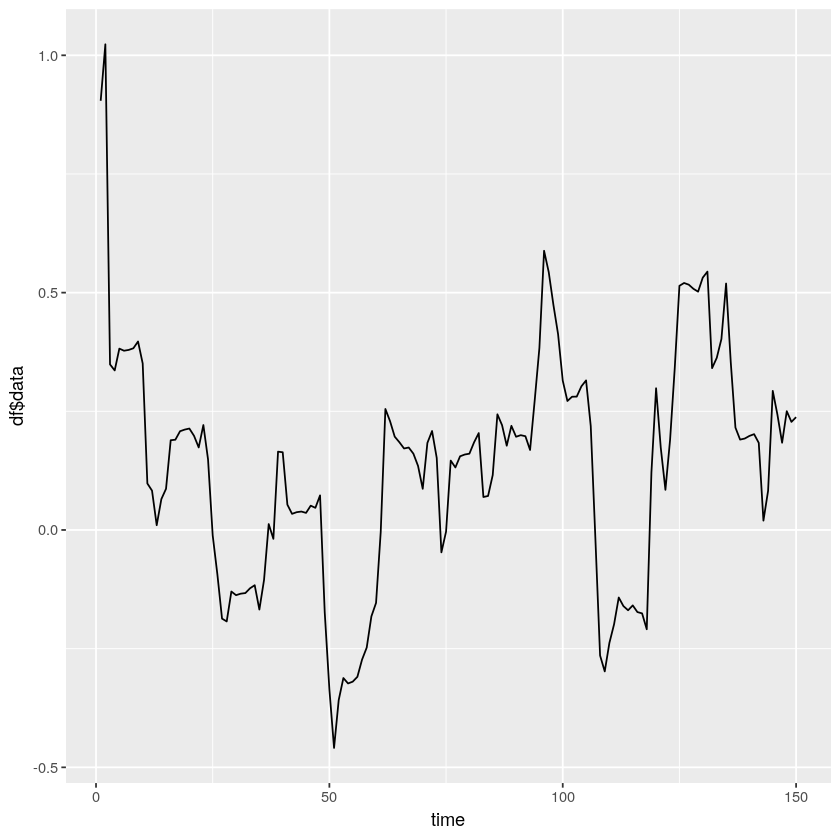

In [86]:
library(ggplot2)
df<-data.frame(data)
time <- 1:length(data)
ggplot(df, aes(x = time ))+ geom_line(data = df, aes(y = df$data))

In [87]:
test <- tail(data,10)

In [88]:
data<-head( data, -10)

In [89]:
data

[1]  0.904159546  1.023110628  0.348757029  0.336124301  0.382043242
  [6]  0.377635479  0.379317164  0.382797360  0.397068501  0.350761414
 [11]  0.097955942  0.082844019  0.010056734  0.065062523  0.086804509
 [16]  0.189086676  0.190164089  0.208011508  0.211467266  0.213704705
 [21]  0.198328376  0.173898339  0.221032500  0.148646355 -0.011495829
 [26] -0.093349934 -0.186761379 -0.192669511 -0.129623294 -0.137319922
 [31] -0.134191871 -0.132874966 -0.122804523 -0.116388440 -0.167601347
 [36] -0.105212569  0.012421727 -0.018611670  0.164987683  0.163745165
 [41]  0.053335428  0.034001350  0.037517071  0.038843393  0.036016464
 [46]  0.051202297  0.046669960  0.072888851 -0.173028708 -0.335501075
 [51] -0.459070086 -0.358197689 -0.311883450 -0.323281646 -0.319536090
 [56] -0.309318423 -0.273087502 -0.247716427 -0.182024598 -0.153597951
 [61] -0.004262924  0.254890680  0.229151726  0.196563601  0.184834361
 [66]  0.171665549  0.173724771  0.160743594  0.134875298  0.086778998
 [71]  0.183408976  0.208499670  0.151735067 -0.047106743 -0.003548503
 [76]  0.146186590  0.131728292  0.155210614  0.158950806  0.160743594
 [81]  0.184620142  0.204103589  0.069442749  0.071663737  0.115739107
 [86]  0.243653655  0.220717907  0.177558064  0.219402552  0.196402907
 [91]  0.199734688  0.197517514  0.168571472  0.273774862  0.383689761
 [96]  0.588132977  0.543139219  0.474268317  0.412553549  0.314699769
[101]  0.271728277  0.280737519  0.280957937  0.302681923  0.315103054
[106]  0.218822360 -0.019557834 -0.264424562 -0.297894835 -0.237753153
[111] -0.198550105 -0.142244220 -0.160305500 -0.169142723 -0.158884883
[116] -0.172932625 -0.175685287 -0.209144592  0.121024013  0.298529625
[121]  0.173482656  0.084639907  0.190099001  0.341224670  0.514359236
[126]  0.520333886  0.516779780  0.508055210  0.502050042  0.531576276
[131]  0.544241667  0.340982318  0.362589002  0.402346849  0.519175291
[136]  0.353512406  0.215699911  0.190409780  0.192631245  0.198158383

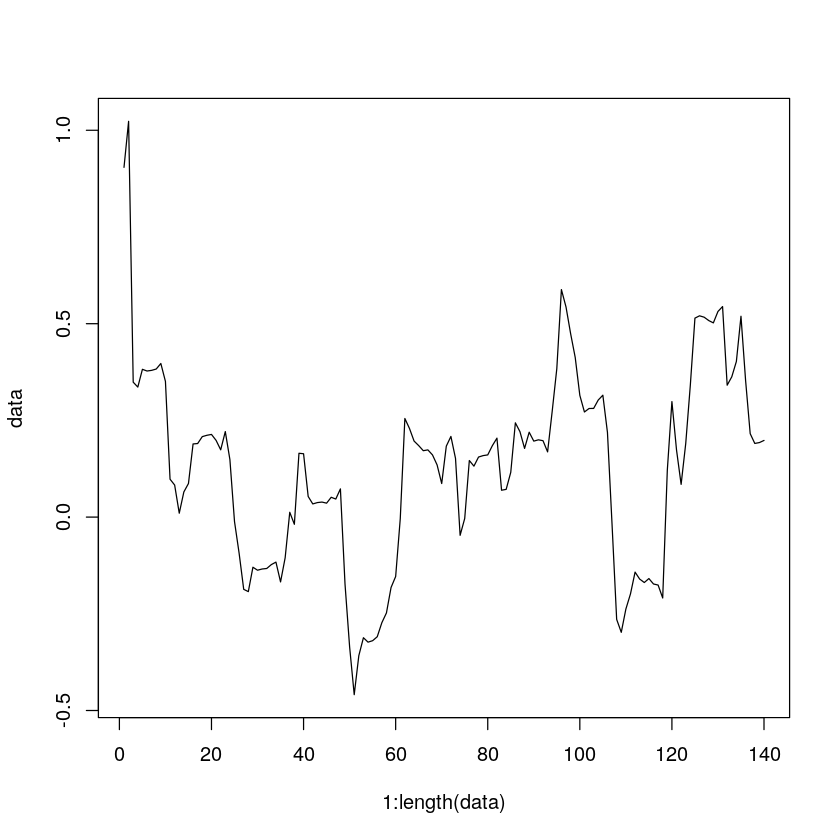

In [90]:
plot(1:length(data),data,type="l")

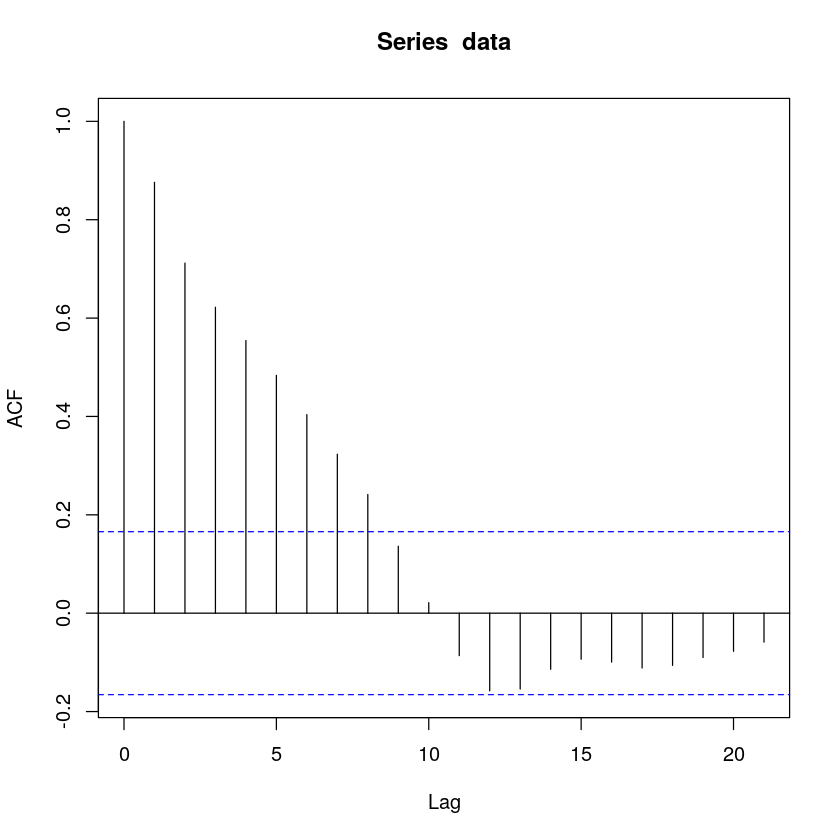

In [91]:
acf(data)

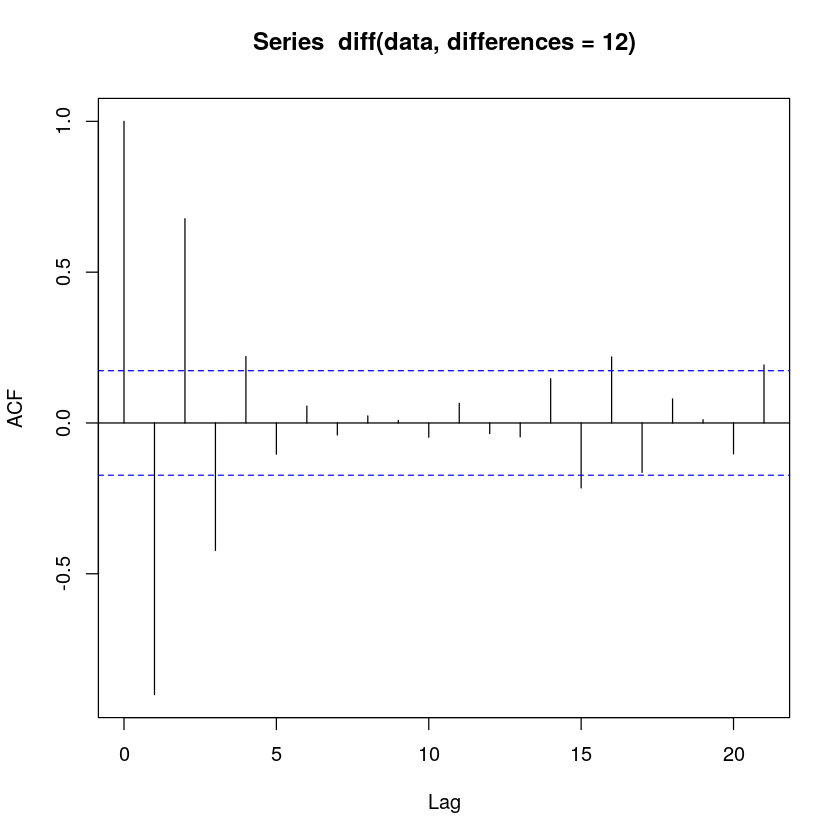

In [92]:
acf(diff(data, differences = 12))

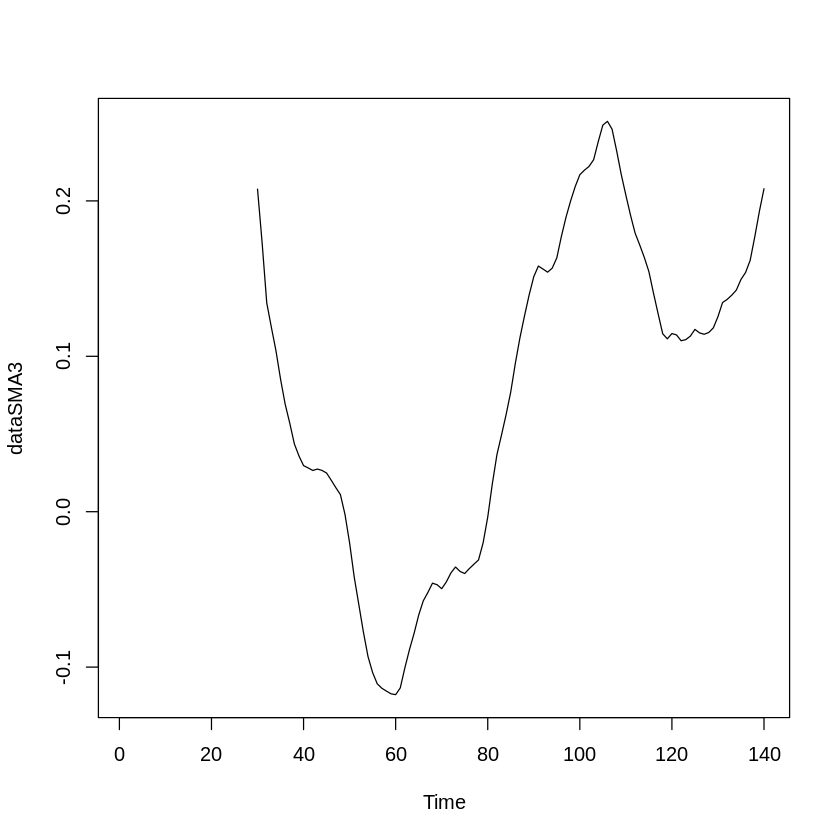

In [20]:
dataSMA3 <- SMA(data,n=30)
plot.ts(dataSMA3)

In [21]:
arima(data, order = c(1,0,0))


Call:
arima(x = data, order = c(1, 0, 0))

Coefficients:
         ar1  intercept
      0.9314     0.1965
s.e.  0.0340     0.1224

sigma^2 estimated as 0.01102:  log likelihood = 115.87,  aic = -225.75

In [133]:
arima(data, order = c(1,0,1))


Call:
arima(x = data, order = c(1, 0, 1))

Coefficients:
         ar1      ma1  intercept
      0.9316  -0.0386     0.0060
s.e.  0.0138   0.0349     0.1877

sigma^2 estimated as 0.14:  log likelihood = -330.89,  aic = 669.79

In [22]:
adf.test(data, alternative = "stationary", k=12)


	Augmented Dickey-Fuller Test

data:  data
Dickey-Fuller = -2.9983, Lag order = 12, p-value = 0.161
alternative hypothesis: stationary


In [96]:
fitARIMA <- arima(x.train, order=c(0,1,1),seasonal = list(order = c(1,0,0), period = 12),method="ML")
library(lmtest)
coeftest(fitARIMA)


z test of coefficients:

      Estimate Std. Error z value Pr(>|z|)
ma1   0.027370   0.054432  0.5028   0.6151
sar1 -0.023714   0.052748 -0.4496   0.6530


In [97]:
fitARIMA <- arima(data, order=c(0,1,1),method="ML")
library(lmtest)
coeftest(fitARIMA)


z test of coefficients:

    Estimate Std. Error z value Pr(>|z|)  
ma1 0.207043   0.091605  2.2602  0.02381 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [98]:
confint(fitARIMA)

2.5 %      97.5 %  
ma1 0.02750022 0.386586

ERROR: Error in eval(expr, envir, enclos): object 'boxresult' not found


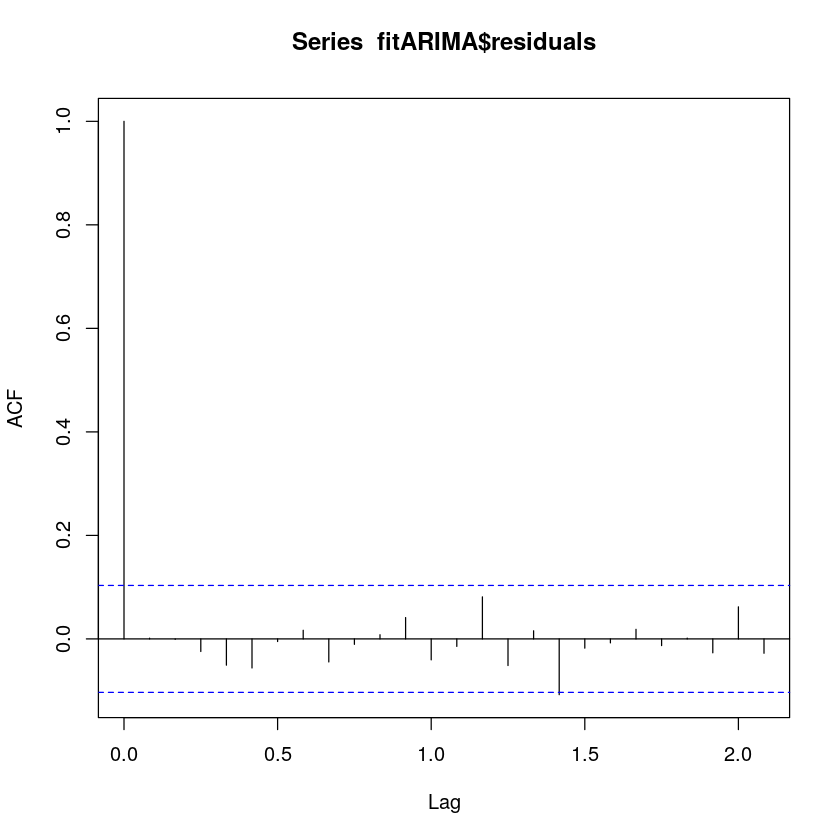

In [60]:
acf(fitARIMA$residuals)

boxresult-LjungBoxTest (fitARIMA$residuals,k=2,StartLag=1)
plot(boxresult[,3],main= "Ljung-Box Q Test", ylab= "P-values", xlab= "Lag")
qqnorm(fitARIMA$residuals)
qqline(fitARIMA$residuals)

In [100]:
fit = auto.arima(data, trace=TRUE)


 ARIMA(2,1,2) with drift         : Inf
 ARIMA(0,1,0) with drift         : -224.5235
 ARIMA(1,1,0) with drift         : -226.2762
 ARIMA(0,1,1) with drift         : -227.2043
 ARIMA(0,1,0)                    : -226.2657
 ARIMA(1,1,1) with drift         : -225.4429
 ARIMA(0,1,2) with drift         : -226.0537
 ARIMA(1,1,2) with drift         : -224.0345
 ARIMA(0,1,1)                    : -229.1018
 ARIMA(1,1,1)                    : -227.3649
 ARIMA(0,1,2)                    : -227.9558
 ARIMA(1,1,2)                    : -226.0088

 Best model: ARIMA(0,1,1)                    



In [95]:
predict(fitARIMA,n.ahead = 24)

$pred
             Jan         Feb         Mar         Apr         May         Jun
2010 -0.13139409 -0.23912971 -0.02679060 -0.01274157 -0.01644511 -0.01694706
2011 -0.01688395 -0.01688395 -0.01688395 -0.01688395 -0.01688395 -0.01688395
             Jul         Aug         Sep         Oct         Nov         Dec
2010 -0.01689671 -0.01688332 -0.01688364 -0.01688394 -0.01688395 -0.01688395
2011 -0.01688395 -0.01688395 -0.01688395 -0.01688395 -0.01688395 -0.01688395

$se
           Jan       Feb       Mar       Apr       May       Jun       Jul
2010 0.6708666 0.8620187 0.9418565 0.9419056 0.9419353 0.9419355 0.9419355
2011 0.9419355 0.9419355 0.9419355 0.9419355 0.9419355 0.9419355 0.9419355
           Aug       Sep       Oct       Nov       Dec
2010 0.9419355 0.9419355 0.9419355 0.9419355 0.9419355
2011 0.9419355 0.9419355 0.9419355 0.9419355 0.9419355


In [62]:
test

ERROR: Error in eval(expr, envir, enclos): object 'test' not found


In [63]:
futurVal

ERROR: Error in eval(expr, envir, enclos): object 'futurVal' not found


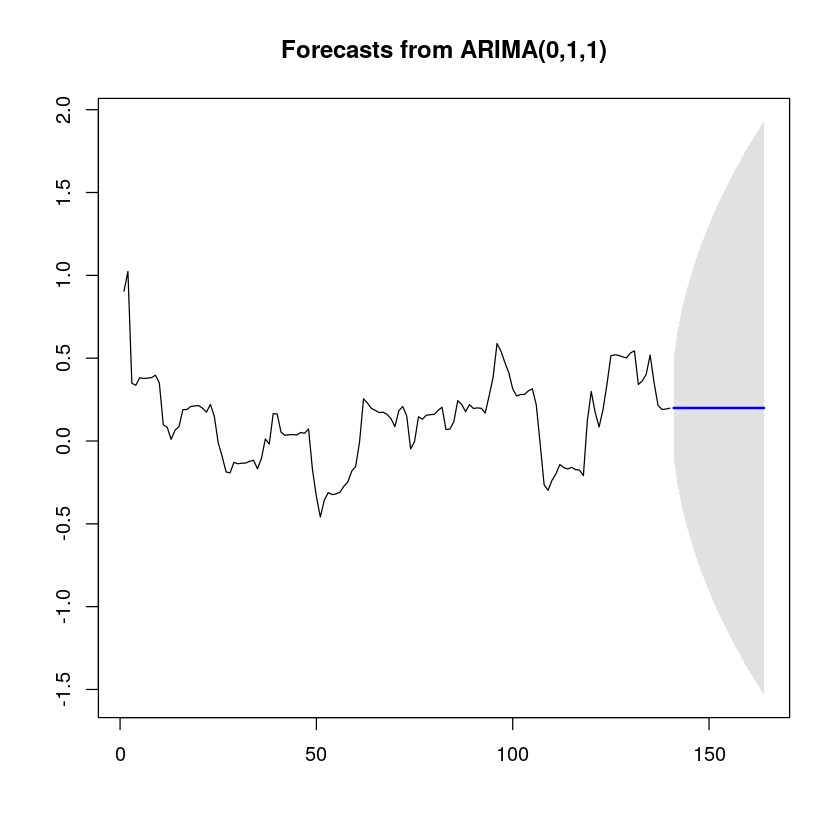

In [102]:
futurVal <- forecast(fit,h=24, level=c(99.5))
plot(futurVal)

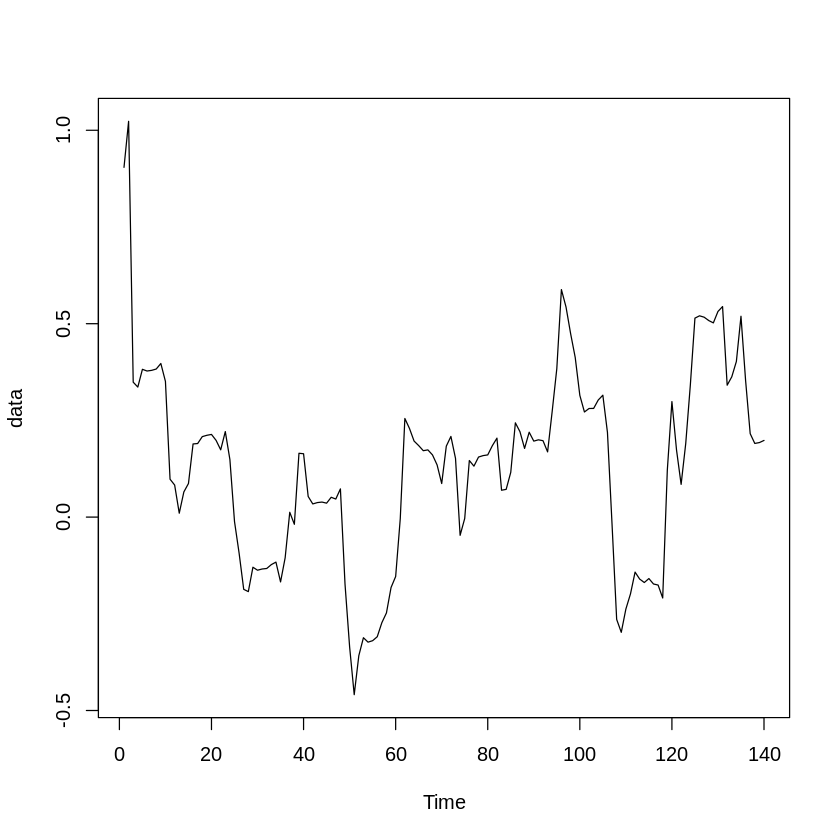

In [31]:
plot.ts(data)